(46, 200, 9)
<KeysViewHDF5 ['layer_0', 'layer_1', 'layer_2']>
(46, 200, 512)
(46, 200, 512)
(46, 200, 512)
Action shape: (46, 200, 9)
Qpos shape: (46, 200, 4)


/tmp/ipykernel_3073135/3574733023.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)


Embedding dimension for time: 1
Embedding dimension for act0: 7
Embedding dimension for act1: 7
Embedding dimension for act2: 7
Embedding dimension for act3: 6
Embedding dimension for act4: 10
Embedding dimension for act5: 9
Embedding dimension for act6: 7
Embedding dimension for act7: 8
Embedding dimension for act8: 6
Embedding dimension for joint0: 2
Embedding dimension for joint1: 2
Embedding dimension for joint2: 2
Embedding dimension for joint3: 2


CCM action→action:   0%|          | 0/9 [00:00<?, ?it/s]

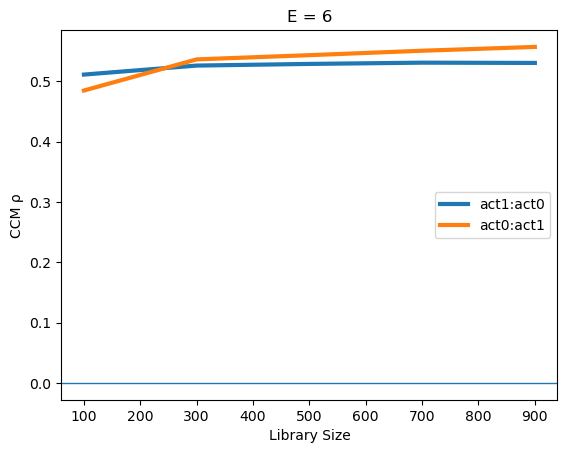

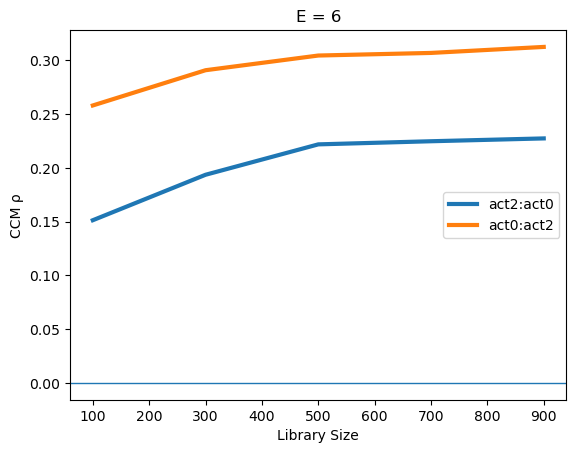

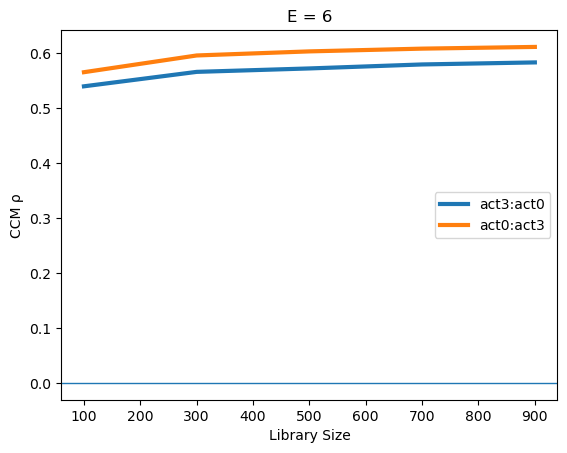

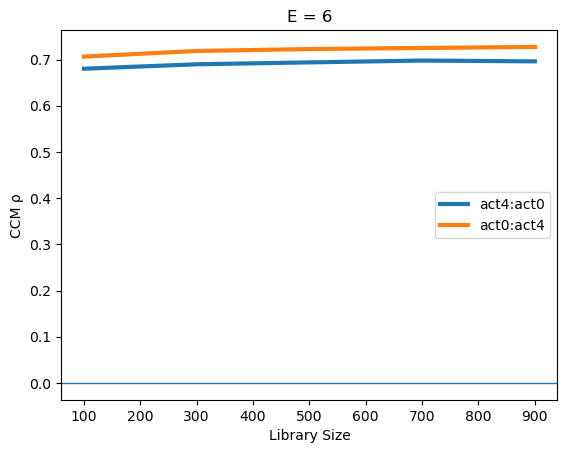

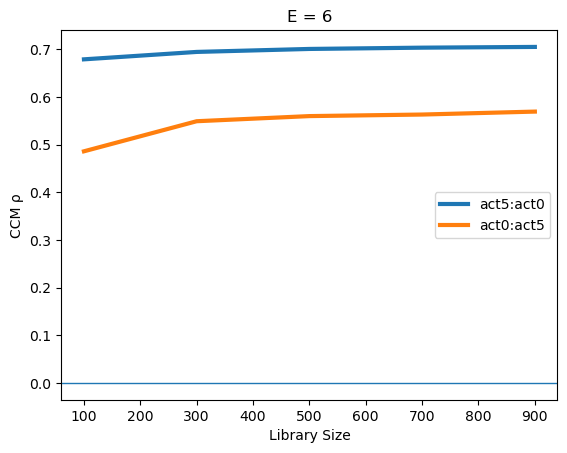

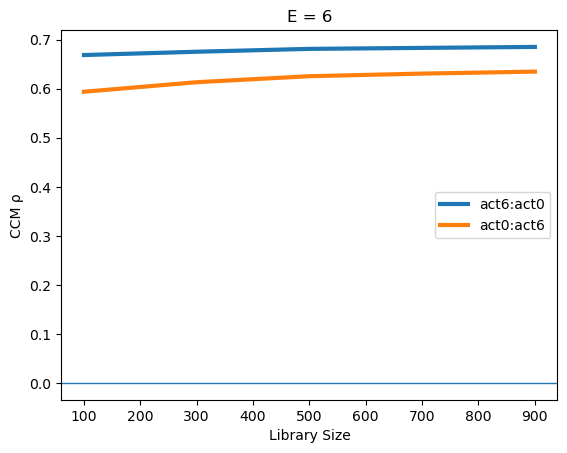

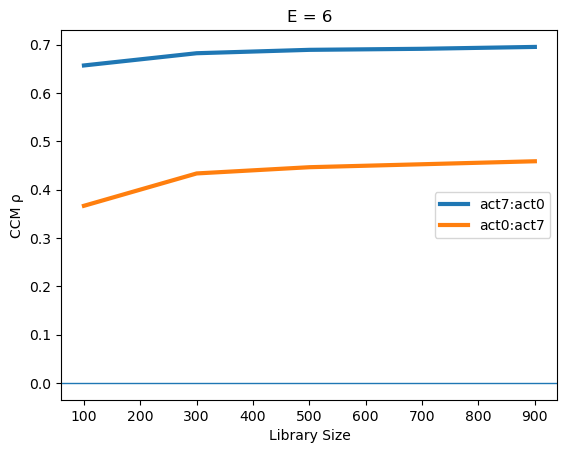

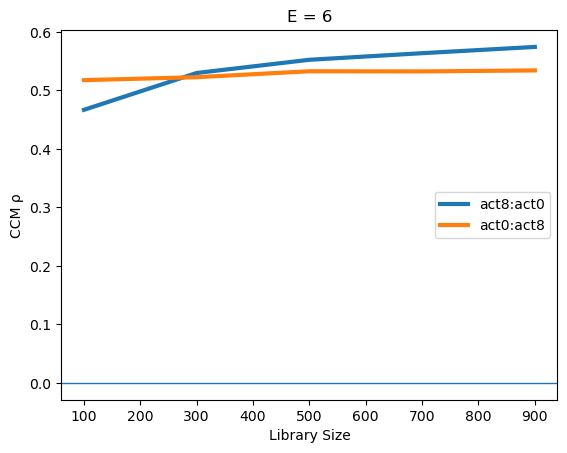

CCM action→action:  11%|█         | 1/9 [00:55<07:26, 55.87s/it]

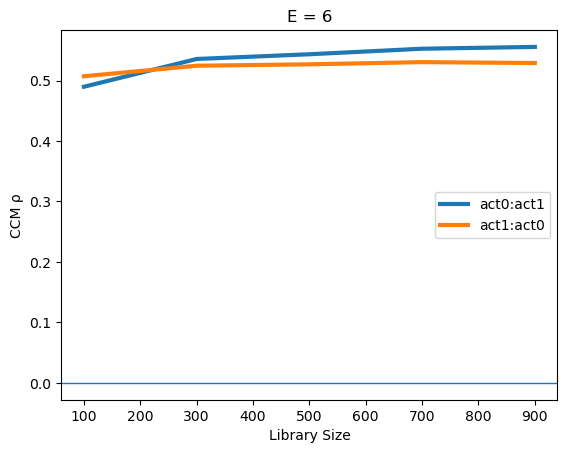

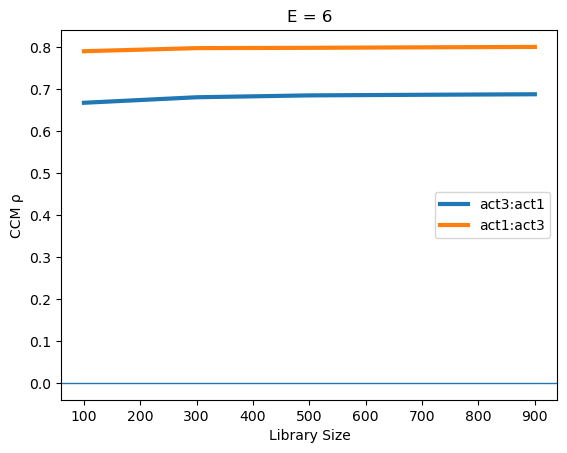

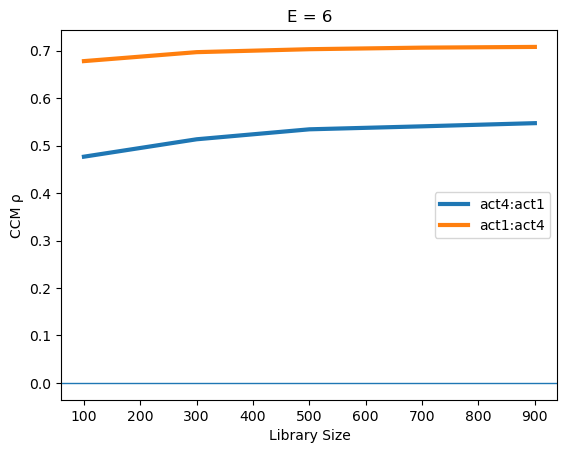

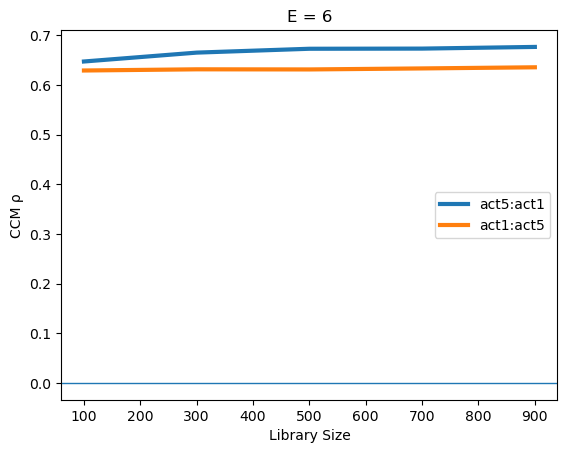

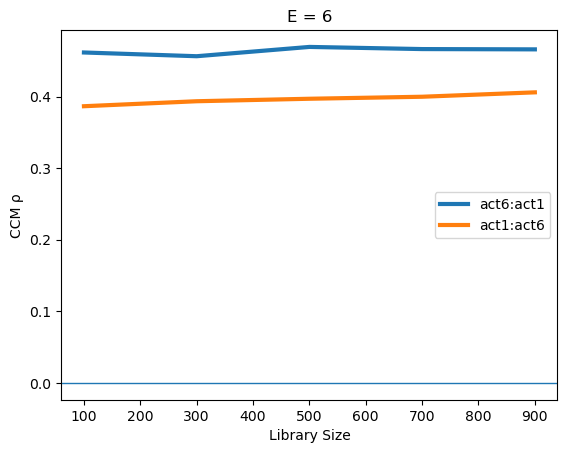

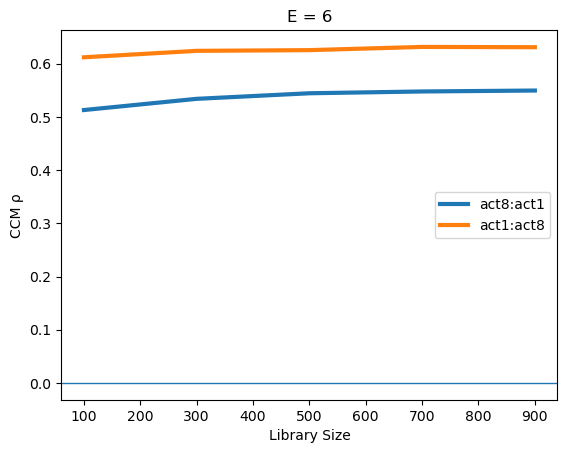

CCM action→action:  22%|██▏       | 2/9 [01:50<06:27, 55.34s/it]

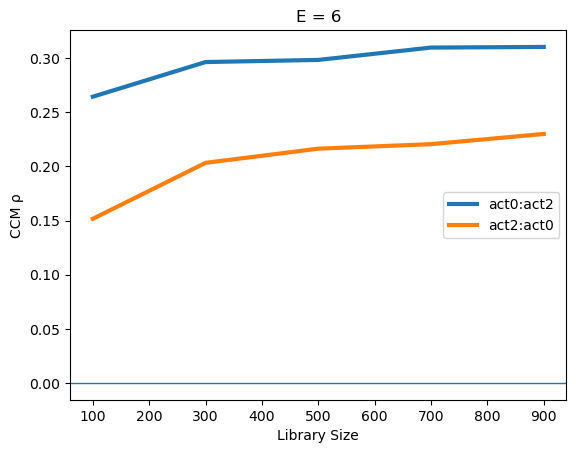

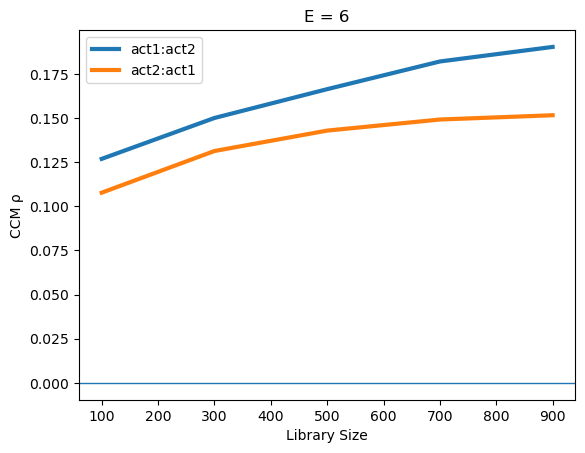

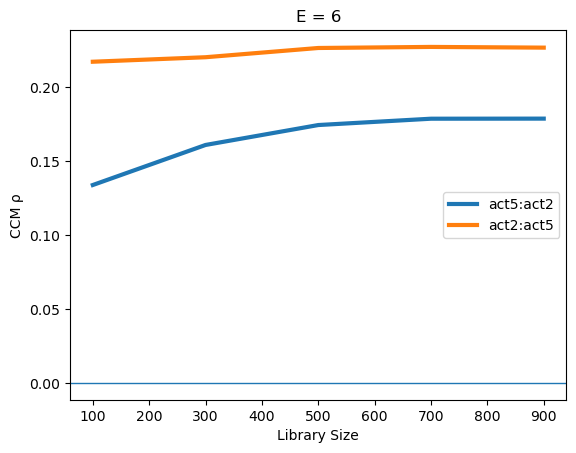

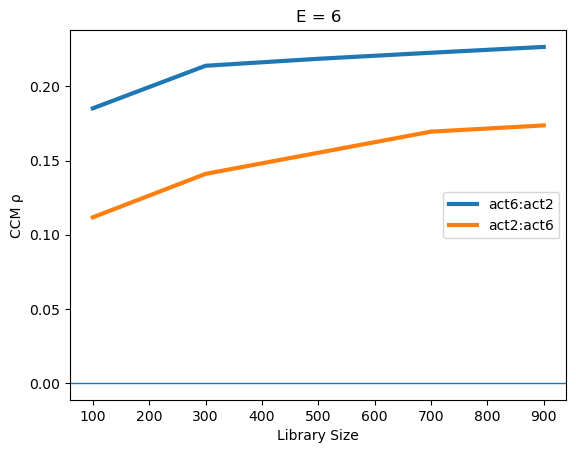

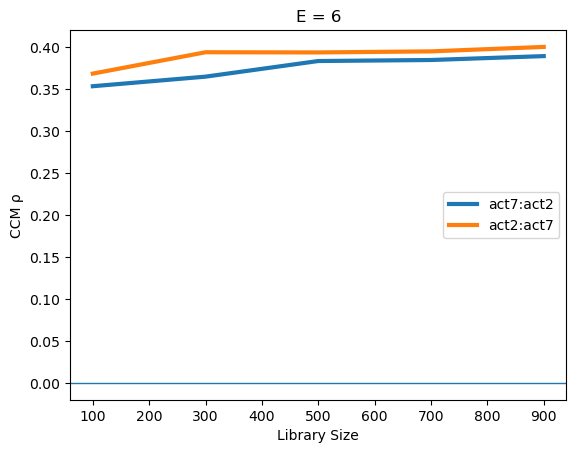

CCM action→action:  33%|███▎      | 3/9 [02:46<05:34, 55.70s/it]

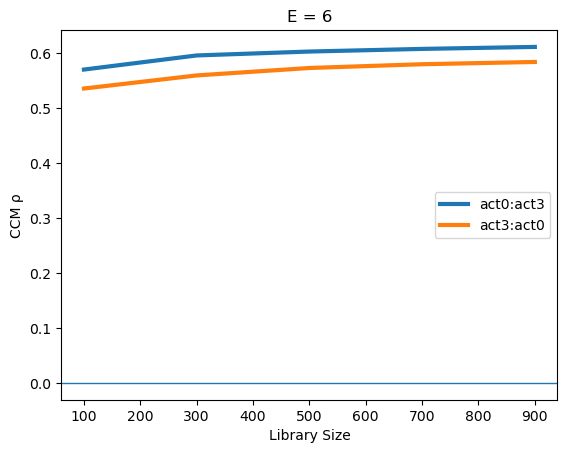

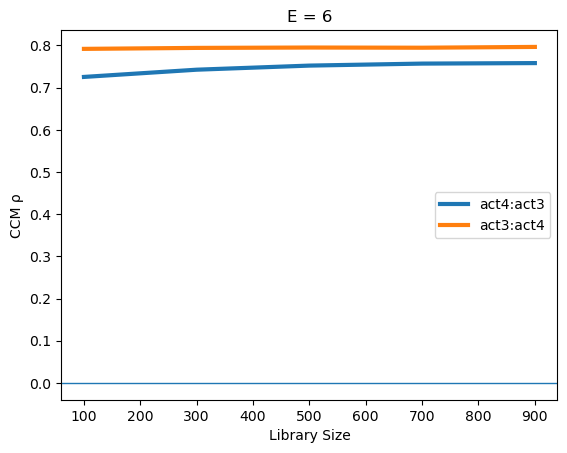

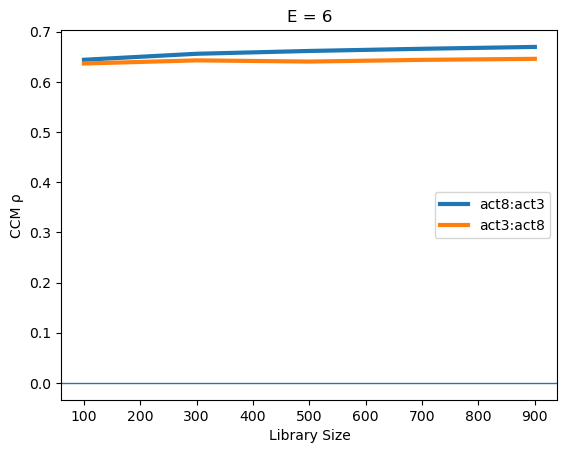

CCM action→action:  44%|████▍     | 4/9 [03:42<04:38, 55.71s/it]

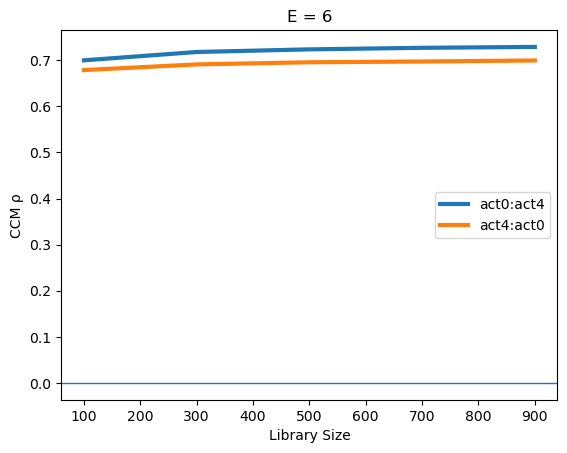

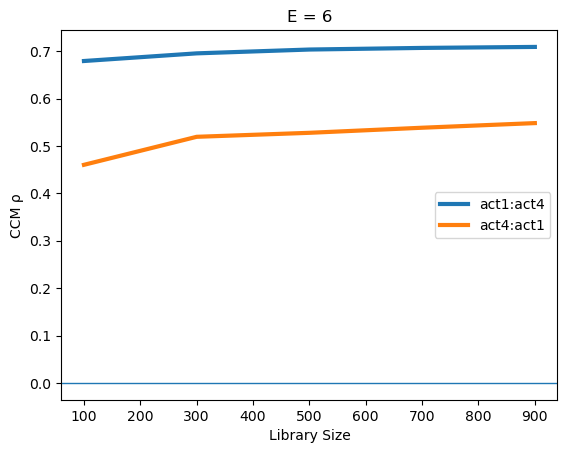

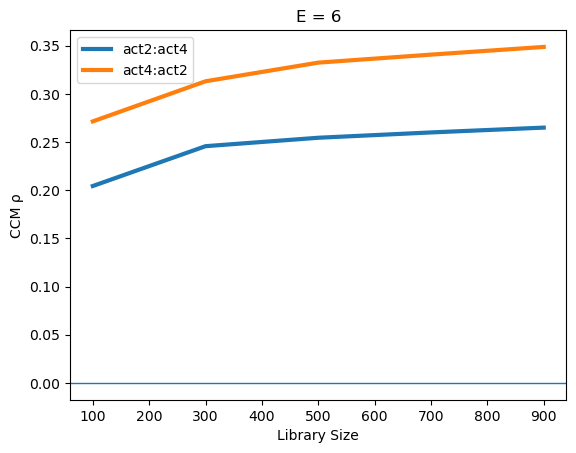

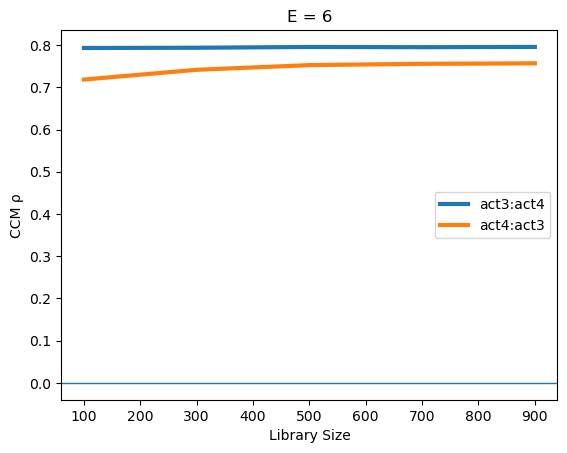

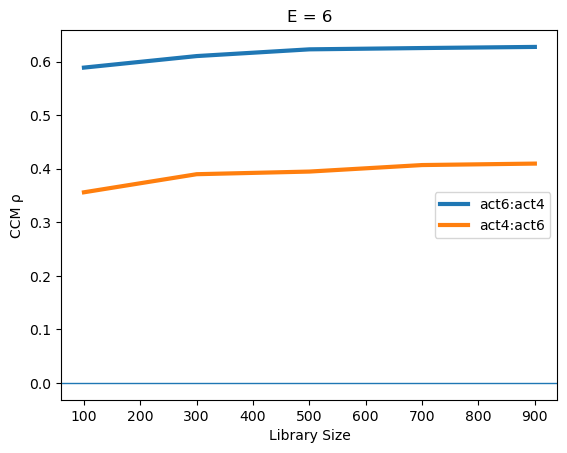

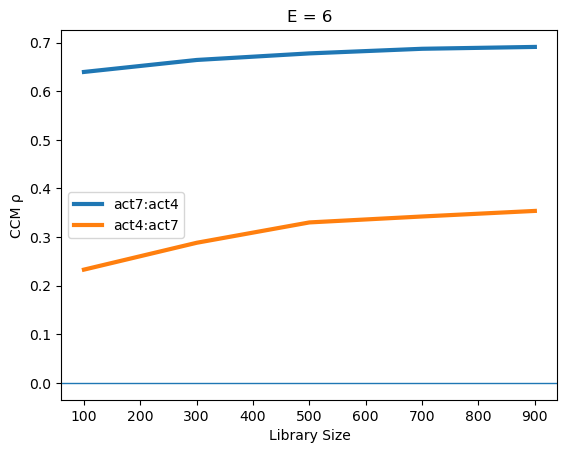

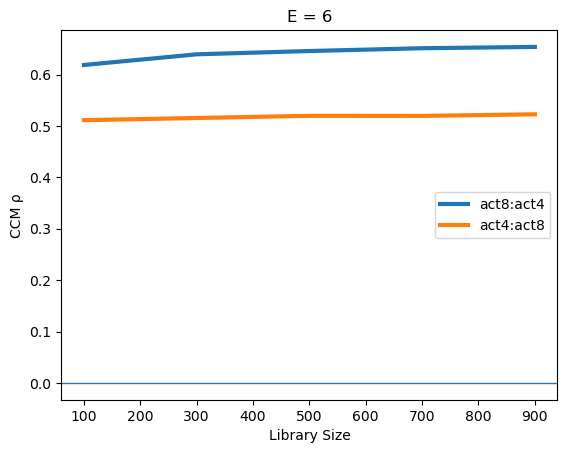

CCM action→action:  56%|█████▌    | 5/9 [04:39<03:43, 55.99s/it]

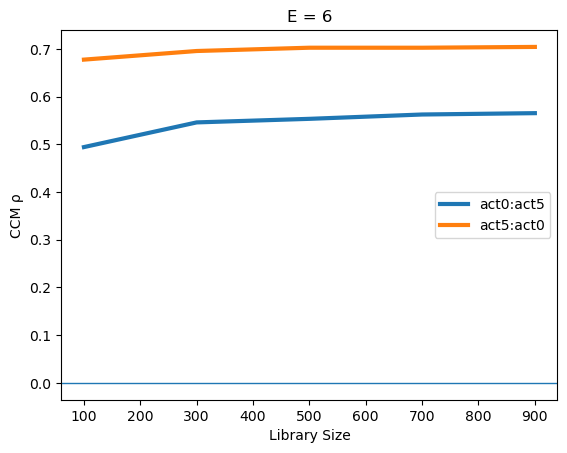

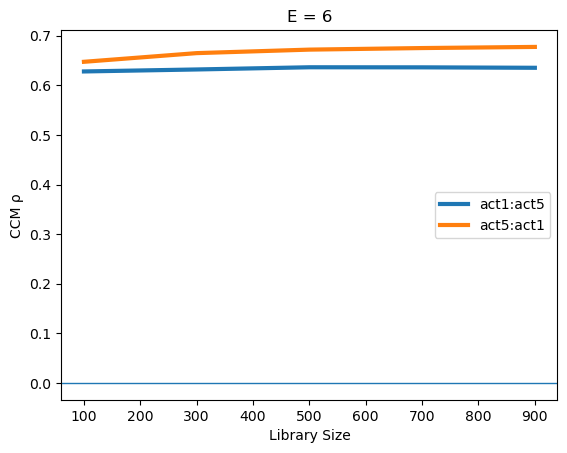

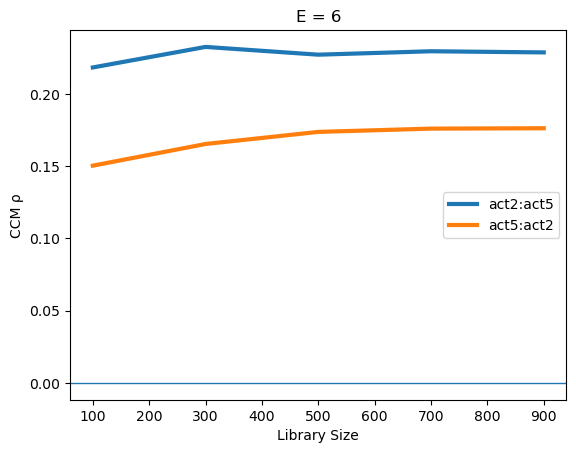

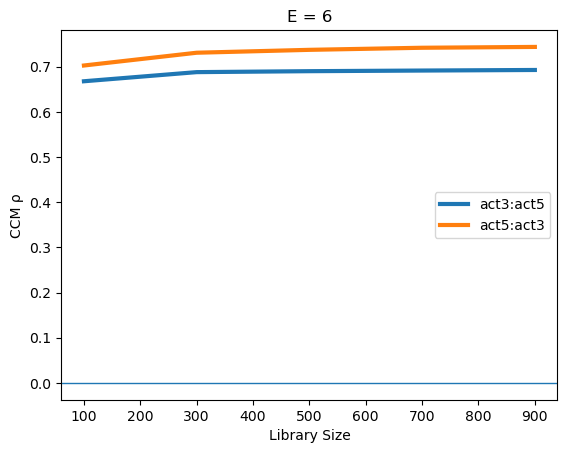

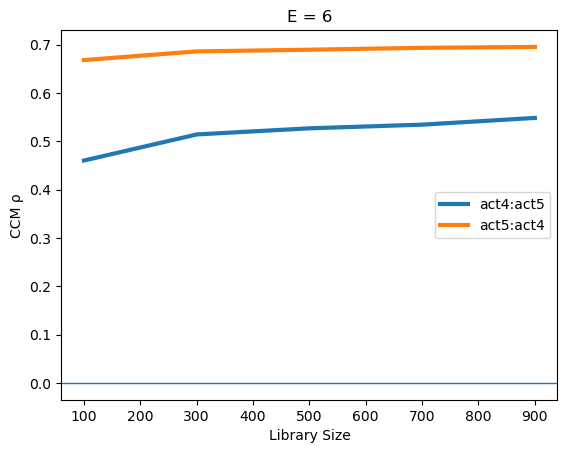

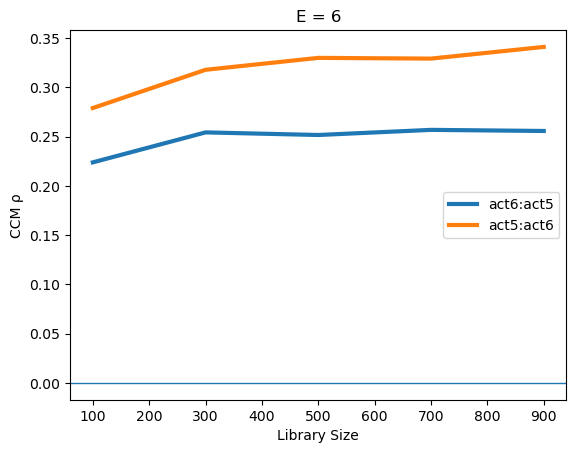

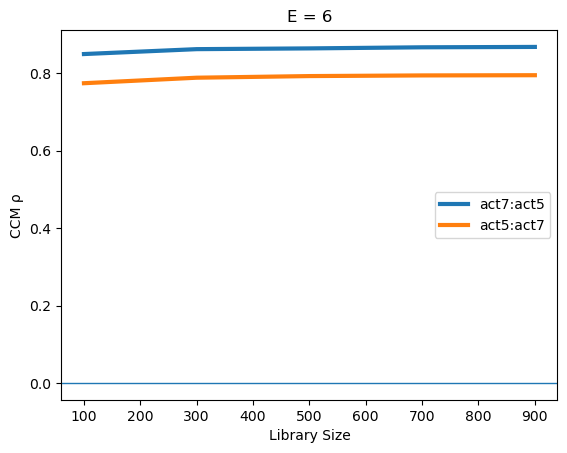

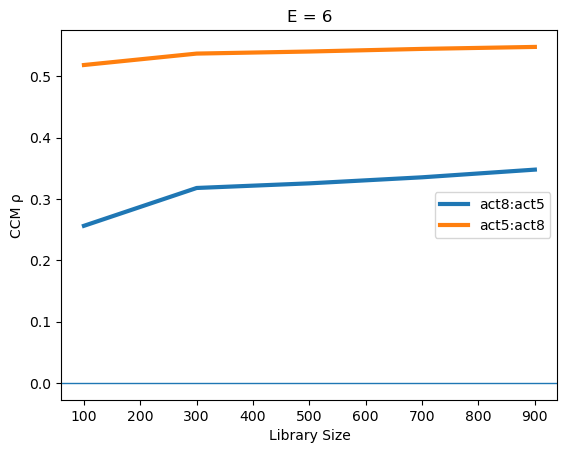

CCM action→action:  67%|██████▋   | 6/9 [05:35<02:48, 56.12s/it]

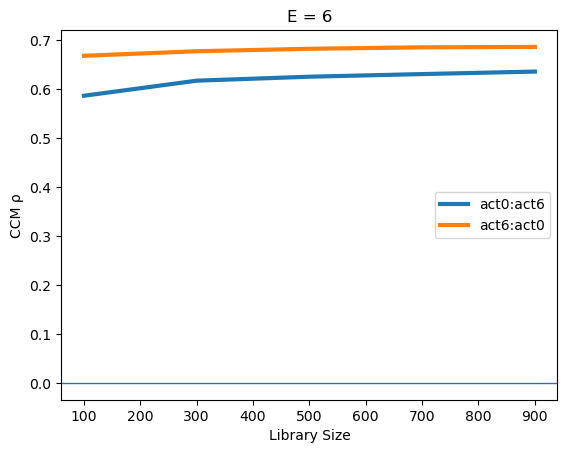

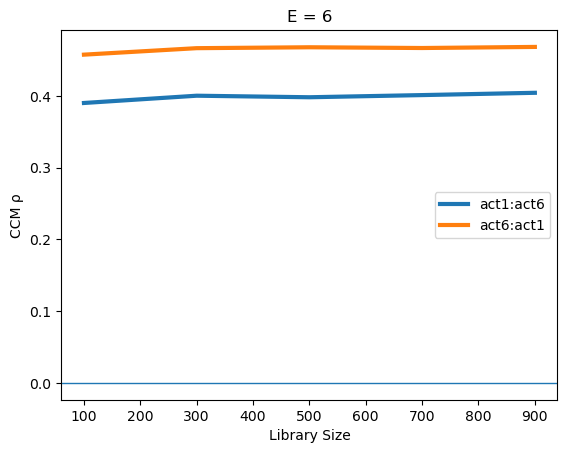

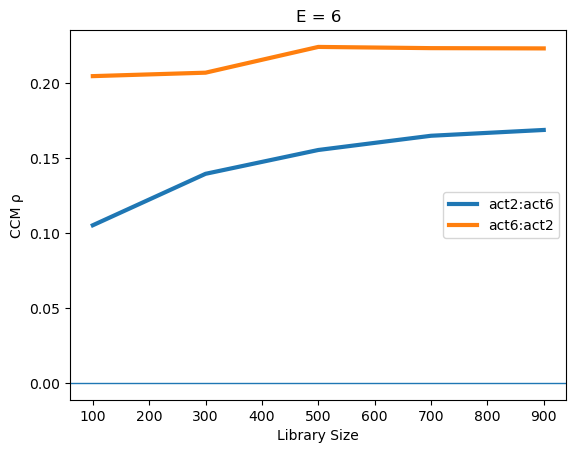

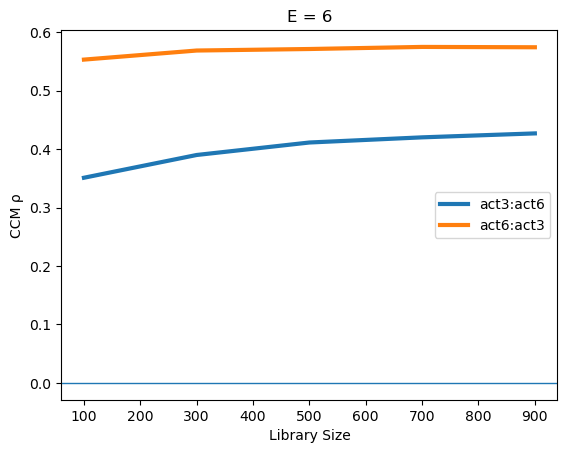

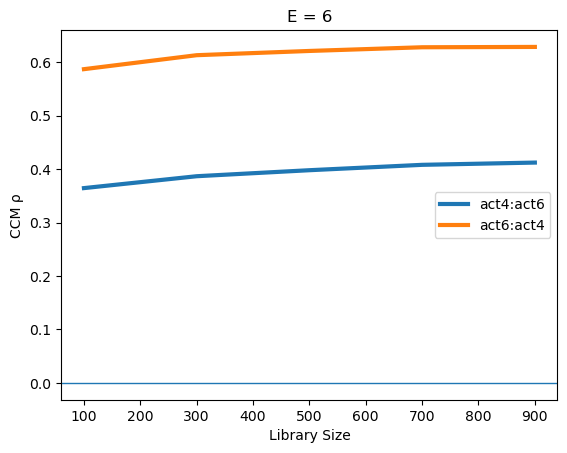

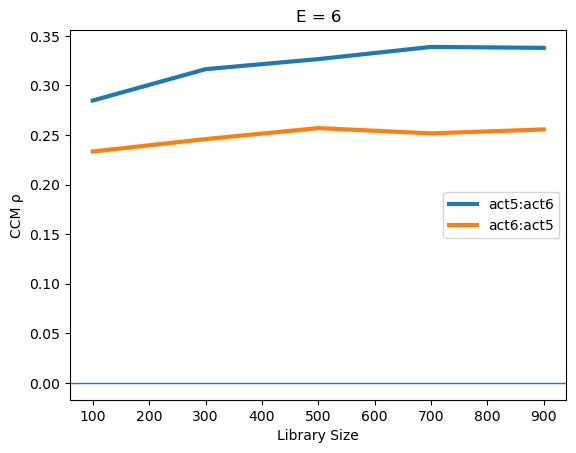

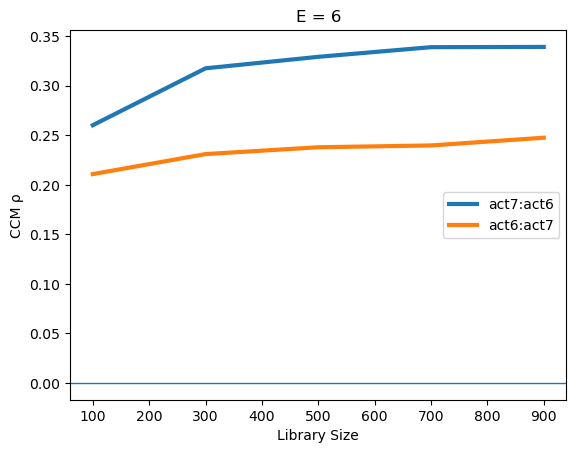

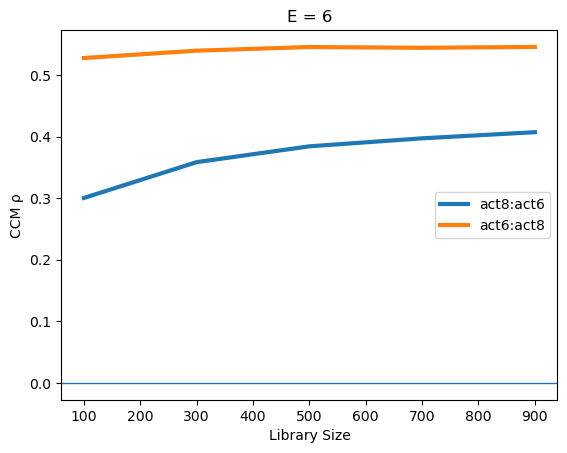

CCM action→action:  78%|███████▊  | 7/9 [06:32<01:52, 56.23s/it]

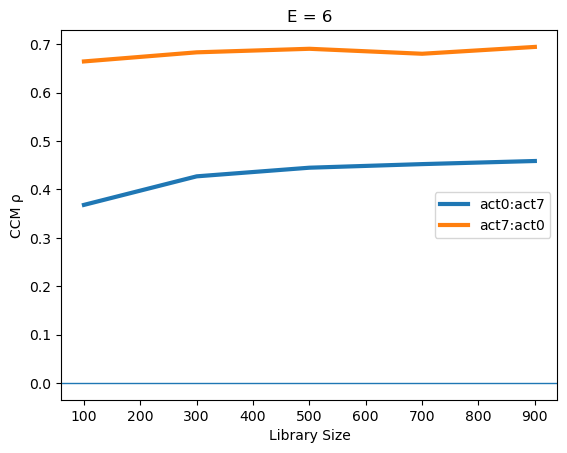

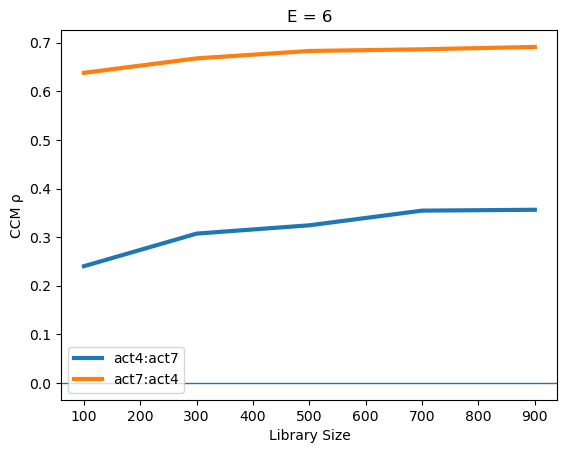

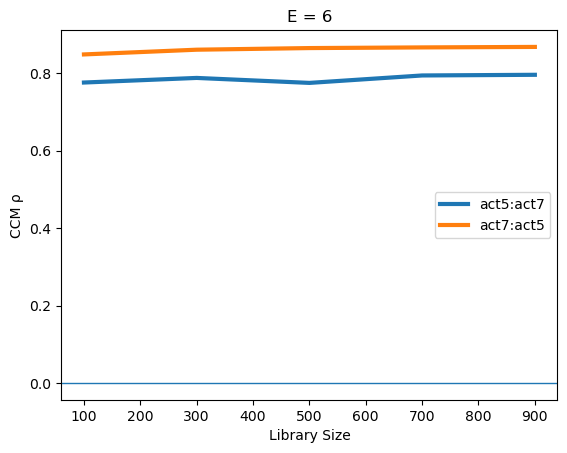

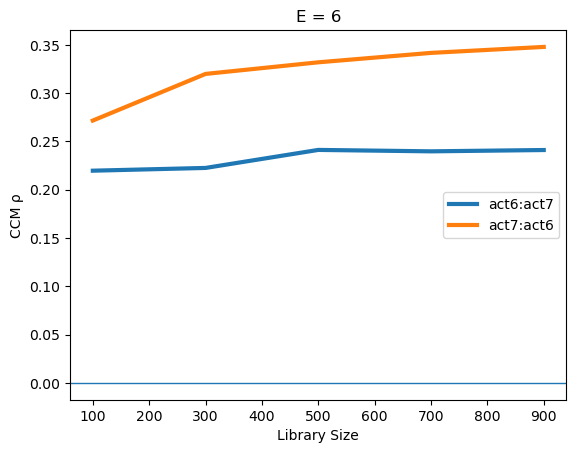

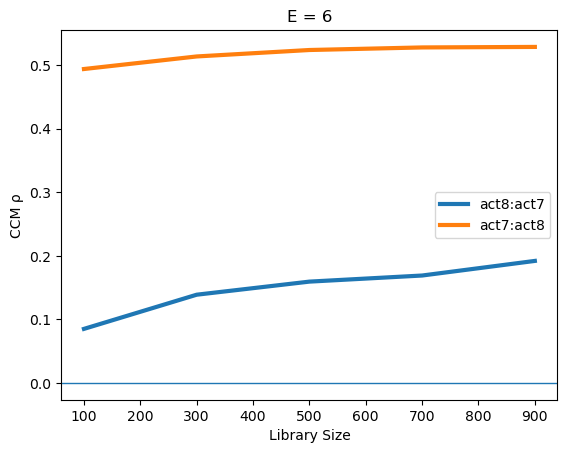

CCM action→action:  89%|████████▉ | 8/9 [07:29<00:56, 56.79s/it]

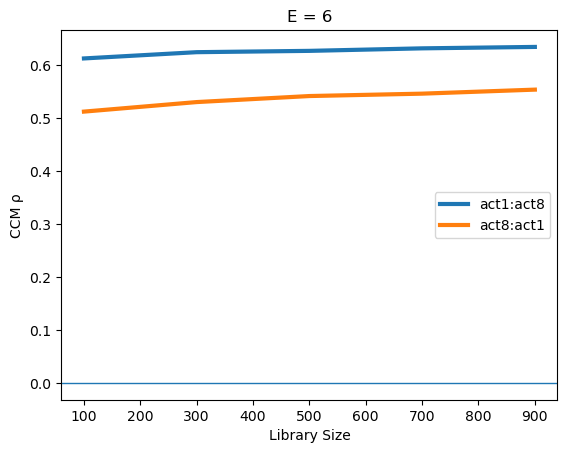

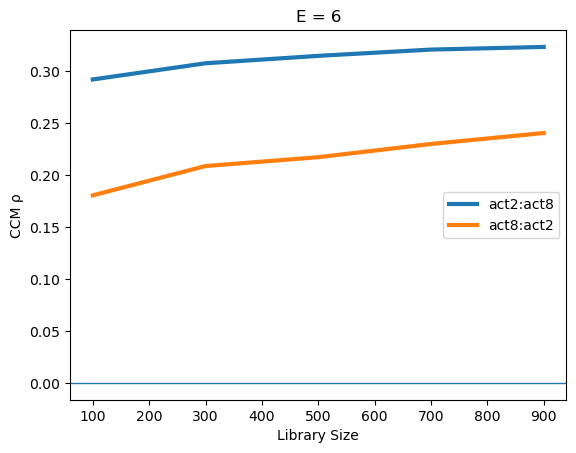

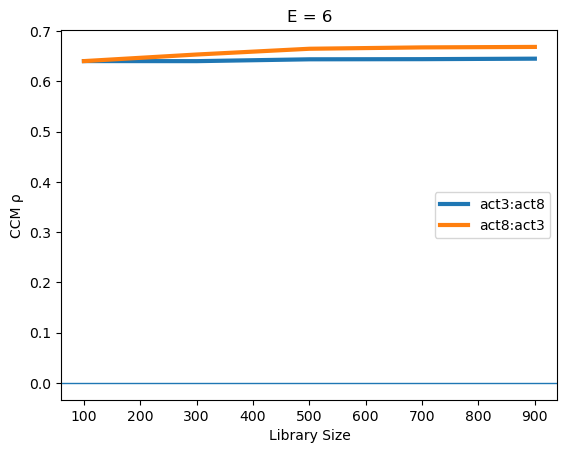

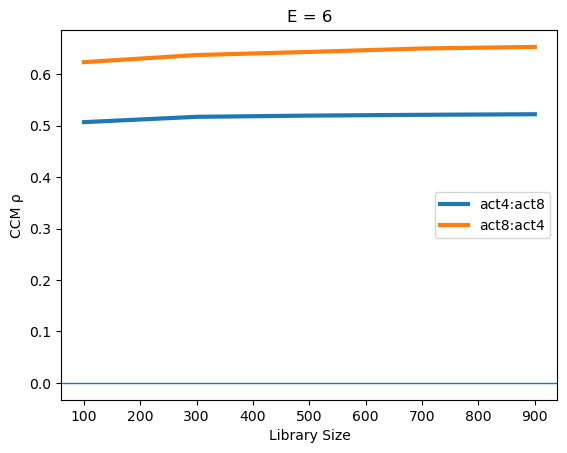

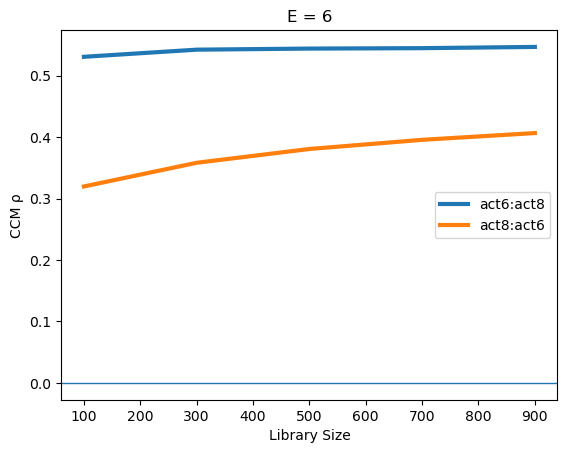

CCM action→action: 100%|██████████| 9/9 [08:26<00:00, 56.30s/it]


In [7]:
# === CCM analysis between all action pairs ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM
from tqdm import tqdm

import pandas as pd
from pyEDM import *
import h5py
import matplotlib.pyplot as plt

## CCM Sensitivity Analysis 

## Load data for muscle activations (actions) and joint angles (qpos)
H5_Path = "rollouts_full_mouse_arm.h5"

with h5py.File(H5_Path, "r") as f:
    actions = f["actions"][...]
    qpos = f["qpos"][...]
    ref_qpos = f["ref_qpos"][...]
    decoder_activations = f["decoder_activations"]
    layer_0 = f["decoder_activations/layer_0"][:]
    layer_1 = f["decoder_activations/layer_1"][:]
    layer_2 = f["decoder_activations/layer_2"][:]
    intentions = f["intentions"][:]

    print(intentions.shape)
    print(decoder_activations.keys())
    print(layer_0.shape)
    print(layer_1.shape)
    print(layer_2.shape)

#actions is a 46 clips by 100 frames by 9 actions
print(f"Action shape: {actions.shape}")

#qpos is a 46 clips by 100 frames by 4 joint angles
print(f"Qpos shape: {qpos.shape}")
action_name = ["Pec_C", "Lat", "PD", "AD", "MD", "Triceps_Lateral", "Triceps_Long", "Brachialis", "Biceps_Long"]
qpos_name = ["sh_elv", "sh_ext", "sh_rot", "elbow"]

import numpy as np, pandas as pd

def plot_ccm_heatmap_from_csv(
    csv_path: str,
    title: str = "CCM ρ (actions → joints), plateau avg",
    output_png: str | None = None,
    annotate: bool = True,
) -> pd.DataFrame:
    """
    Load a (rows × columns) CCM matrix from CSV and plot a labeled heatmap.
    Labels (row index and column names) are used exactly as in the CSV.

    Args:
        csv_path: Path to CSV. First column must be row labels (e.g., muscles).
        title: Figure title string.
        output_png: If provided, save figure to this path; otherwise <csv_basename>.png.
        annotate: If True, annotate each cell with its numeric value.

    Returns:
        The DataFrame used to draw the heatmap.
    """
    # 1) Load exactly as-is (no renaming)
    df = pd.read_csv(csv_path, index_col=0)
    # Coerce to float where possible (keeps labels intact)
    df = df.apply(pd.to_numeric, errors="coerce")

    # 2) Plot
    fig_w = 1.2 * len(df.columns) + 2
    fig_h = 1.2 * len(df.index) + 2
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(df.values, aspect="auto")
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index)
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("ρ")

    # 3) Optional annotations with contrast-aware text color
    if annotate:
        vals = df.values
        vmin = np.nanmin(vals) if np.isfinite(vals).any() else 0.0
        vmax = np.nanmax(vals) if np.isfinite(vals).any() else 1.0
        thresh = (vmin + vmax) / 2.5
        for i in range(vals.shape[0]):
            for j in range(vals.shape[1]):
                v = vals[i, j]
                txt = "nan" if np.isnan(v) else f"{v:.2f}"
                color = "black" if (not np.isnan(v) and v >= thresh) else "white"
                ax.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)

    plt.tight_layout()

    # 4) Save if requested (default = same basename as CSV)
    if output_png is None:
        base, _ = os.path.splitext(os.path.basename(csv_path))
        output_png = f"{base}.png"
    plt.savefig(output_png, dpi=150)
    plt.show()

    return df

def concat_with_large_nan_padding(actions, qpos, pad=300, standardize=True):
    """
    Concatenate all clips into one long DataFrame with big NaN blocks between clips.
    Safe for pyEDM with ignoreNan=True.

    Args:
        actions: (N, T, 9)
        qpos:    (N, T, 4)
        pad:     number of NaN rows to insert between clips
        standardize: z-score each series per clip

    Returns:
        big_df: DataFrame with columns ['time','act0'..'act8','joint0'..'joint3']
        clip_ranges: dict {clip_idx: (start,end)} 1-based row indices (excluding NaNs)
    """
    N, T, A = actions.shape
    _, T2, J = qpos.shape
    assert T == T2 and A == 9 and J == 4

    def _z(x):
        mu, sd = np.nanmean(x), np.nanstd(x)
        return (x - mu)/sd if sd > 1e-12 else (x - mu)

    frames = []
    clip_ranges = {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({
                "time": np.arange(row_cursor+1, row_cursor+pad+1),
                **{f"act{i}": np.nan for i in range(A)},
                **{f"joint{j}": np.nan for j in range(J)},
            })
            frames.append(pad_df)
            row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        for i in range(A):
            data[f"act{i}"] = _z(actions[c,:,i]) if standardize else actions[c,:,i]
        for j in range(J):
            data[f"joint{j}"] = _z(qpos[c,:,j]) if standardize else qpos[c,:,j]
        clip_df = pd.DataFrame(data)

        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)

        frames.append(clip_df)
        row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

big_df, clip_ranges = concat_with_large_nan_padding(actions, qpos, pad=10)

_keys = big_df.columns.tolist()

from pyEDM import EmbedDimension

for key in _keys:
    # Example: run EmbedDimension on act0 across *all clips* pooled
    res = EmbedDimension(
        dataFrame=big_df,
        columns=key, target=key,
        lib="1 7000", pred="7000 9650",   # pick ranges that are inside big_df length
    ignoreNan=True, numProcess=1, showPlot=False
    )
    embedding_dim = res["rho"].argmax() + 1
    print(f"Embedding dimension for {key}: {embedding_dim}")


def ccm_heatmap_actions_to_actions(
    df: pd.DataFrame,
    action_names: list,
    lib_sizes: str = "100 8000 200",
    samples: int = 50,
    E: int = 3,
    tau: int = -1,
    tail_points: int = 5,
    output_csv: str = "ccm_actions_to_actions.csv",
    output_png: str = "ccm_actions_to_actions.png"
) -> pd.DataFrame:
    """
    Run CCM for all action pairs and create a heatmap.
    
    Args:
        df: DataFrame with actions ('act0' through 'act8')
        action_names: Human-readable names for the actions
        lib_sizes, samples, E, tau: CCM parameters
        tail_points: Number of last library sizes to average for plateau value
        output_csv/output_png: Output file paths
        
    Returns:
        DataFrame with CCM plateau values
    """
    num_actions = len(action_names)
    action_cols = [f"act{i}" for i in range(num_actions)]
    
    # Matrix to store CCM plateau values
    ccm_matrix = np.zeros((num_actions, num_actions))
    
    # Run CCM for each action pair
    for i in tqdm(range(num_actions), desc="CCM action→action"):
        for j in range(num_actions):
            # Skip self-predictions
            if i == j:
                ccm_matrix[i, j] = np.nan
                continue
                
            # action_i → action_j is tested as action_j::action_i
            # (columns=j, target=i)
            try:
                res = CCM(
                    dataFrame=df,
                    columns=action_cols[j], 
                    target=action_cols[i],
                    E=E, tau=tau, Tp=0,
                    libSizes=lib_sizes, sample=samples,
                    ignoreNan=True, showPlot=True
                )
                
                # Get the right column name for this direction
                dir_col = f"{action_cols[j]}:{action_cols[i]}"
                if dir_col in res.columns:
                    rho_series = res[dir_col]
                else:
                    # Fallback: first non-LibSize column
                    rho_series = res.iloc[:, 1]  # Assuming LibSize is first column
                
                # Get plateau value (average of last few points)
                k = min(tail_points, len(rho_series))
                plateau_rho = float(rho_series.iloc[-k:].mean()) if k > 0 else np.nan
                ccm_matrix[i, j] = plateau_rho
                
            except Exception as e:
                print(f"Error for {action_names[i]}→{action_names[j]}: {e}")
                ccm_matrix[i, j] = np.nan
    
    # Create and save DataFrame
    ccm_df = pd.DataFrame(ccm_matrix, index=action_names, columns=action_names)
    ccm_df.to_csv(output_csv, float_format="%.6f")
    
    # Plot heatmap
    plot_ccm_heatmap_from_csv(
        csv_path=output_csv,
        title="CCM ρ (action → action), plateau avg",
        output_png=output_png,
        annotate=True
    )
    
    return ccm_df

# Run the CCM analysis
action_name = ["Pec_C", "Lat", "PD", "AD", "MD", "Triceps_Lateral", "Triceps_Long", "Brachialis", "Biceps_Long"]
ccm_matrix = ccm_heatmap_actions_to_actions(
    df=big_df,
    action_names=action_name,
    lib_sizes="100 1000 200",
    samples=50,
    E=6,
    tau=-1,
    output_csv="ccm_actions_to_actions.csv",
    output_png="ccm_actions_to_actions.png"
)

In [8]:
ccm_matrix

Pec_C       Lat        PD        AD        MD  \
Pec_C                 NaN  0.525813  0.203717  0.568015  0.691638   
Lat              0.535335       NaN  0.139094  0.681686  0.522431   
PD               0.295953  0.163062       NaN  0.176845  0.319520   
AD               0.597855  0.798200  0.139659       NaN  0.747117   
MD               0.719331  0.698684  0.245862  0.794672       NaN   
Triceps_Lateral  0.544157  0.633614  0.227312  0.685914  0.516835   
Triceps_Long     0.619141  0.398754  0.146874  0.399908  0.393907   
Brachialis       0.430258  0.553677  0.390358  0.498353  0.316513   
Biceps_Long      0.526948  0.625399  0.311665  0.642974  0.517234   

                 Triceps_Lateral  Triceps_Long  Brachialis  Biceps_Long  
Pec_C                   0.696206      0.678814    0.682802     0.537410  
Lat                     0.667265      0.463946    0.663696     0.537878  
PD                      0.165365      0.213455    0.375396     0.216511  
AD                      0.731527      0.566099    0.710519     0.659590  
MD                      0.685992      0.615126    0.671923     0.641866  
Triceps_Lateral              NaN      0.248369    0.862421     0.316522  
Triceps_Long            0.320955           NaN    0.317059     0.369504  
Brachialis              0.786140      0.232873         NaN     0.148855  
Biceps_Long             0.535678      0.541893    0.518680          NaN

Suggested number of clusters by eigengap: 1
Synergy 1: PD, Triceps_Lateral, Brachialis
Synergy 2: Pec_C, MD, Triceps_Long, Biceps_Long
Synergy 3: Lat, AD


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


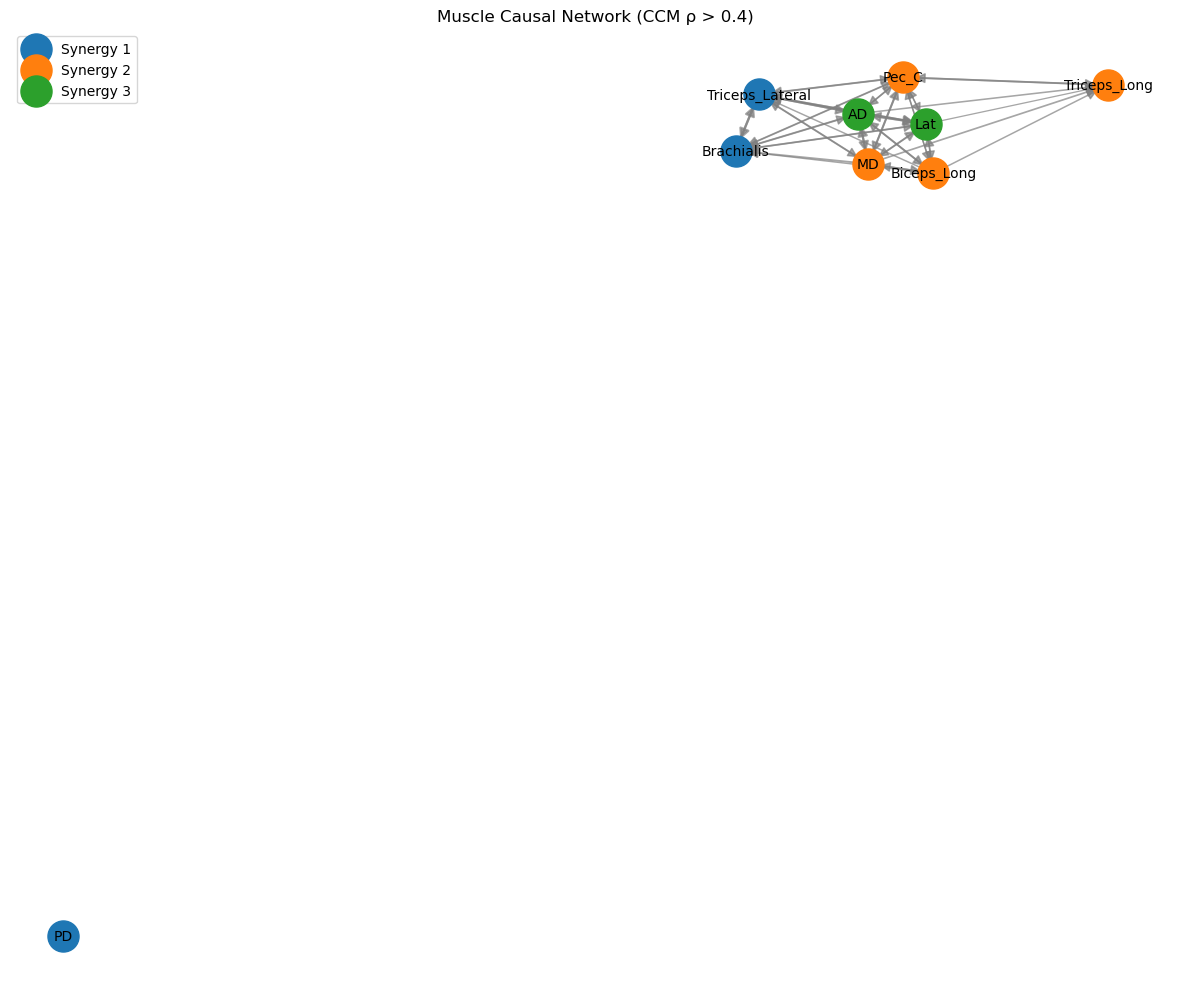

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_df.values

# Handle any remaining NaN values by replacing with zeros
affinity_matrix = np.nan_to_num(affinity_matrix)

# Find optimal number of clusters using eigengap heuristic
from scipy import linalg
laplacian = np.diag(np.sum(affinity_matrix, axis=1)) - affinity_matrix
eigenvalues, _ = linalg.eigh(laplacian)
n_clusters_suggested = np.argmax(np.diff(np.sort(eigenvalues))) + 1
print(f"Suggested number of clusters by eigengap: {n_clusters_suggested}")

# Apply spectral clustering
n_clusters = 3  # Can be adjusted based on eigengap or domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Display muscle synergy groups
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# Reorder the CCM matrix based on clusters
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

# Create reordered matrix
reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

# Plot heatmap with cluster boundaries
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Directed CCM Relationships')
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

# Visualize the causal network with force-directed layout
import networkx as nx

# Create directed graph from CCM matrix
G = nx.DiGraph()

# First add all nodes to ensure they all get positions
for muscle in ccm_df.index:
    G.add_node(muscle)

# Then add edges with weights
for i, source in enumerate(ccm_df.index):
    for j, target in enumerate(ccm_df.columns):
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]):
                # Only add strong connections (threshold can be adjusted)
                if ccm_df.iloc[i, j] > 0.4:
                    G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# Draw graph with node colors based on clusters
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42, k=0.3)

# Draw nodes colored by cluster
for cluster in range(1, n_clusters+1):
    nodes = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, 
                          node_size=500,
                          node_color=f"C{cluster-1}", 
                          label=f"Synergy {cluster}")

# Draw edges with width proportional to CCM strength
edges = G.edges(data=True)
weights = [d['weight']*2 for u,v,d in edges]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7, 
                      arrowsize=15, edge_color='gray')

# Add labels
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Muscle Causal Network (CCM ρ > 0.4)")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.savefig("muscle_causal_network.png", dpi=300)
plt.show()


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Spectral clustering muscle synergies:
Synergy 1: Lat, Triceps_Lateral, Brachialis
Synergy 2: AD, MD, Biceps_Long
Synergy 3: Triceps_Long
Synergy 4: PD
Synergy 5: Pec_C


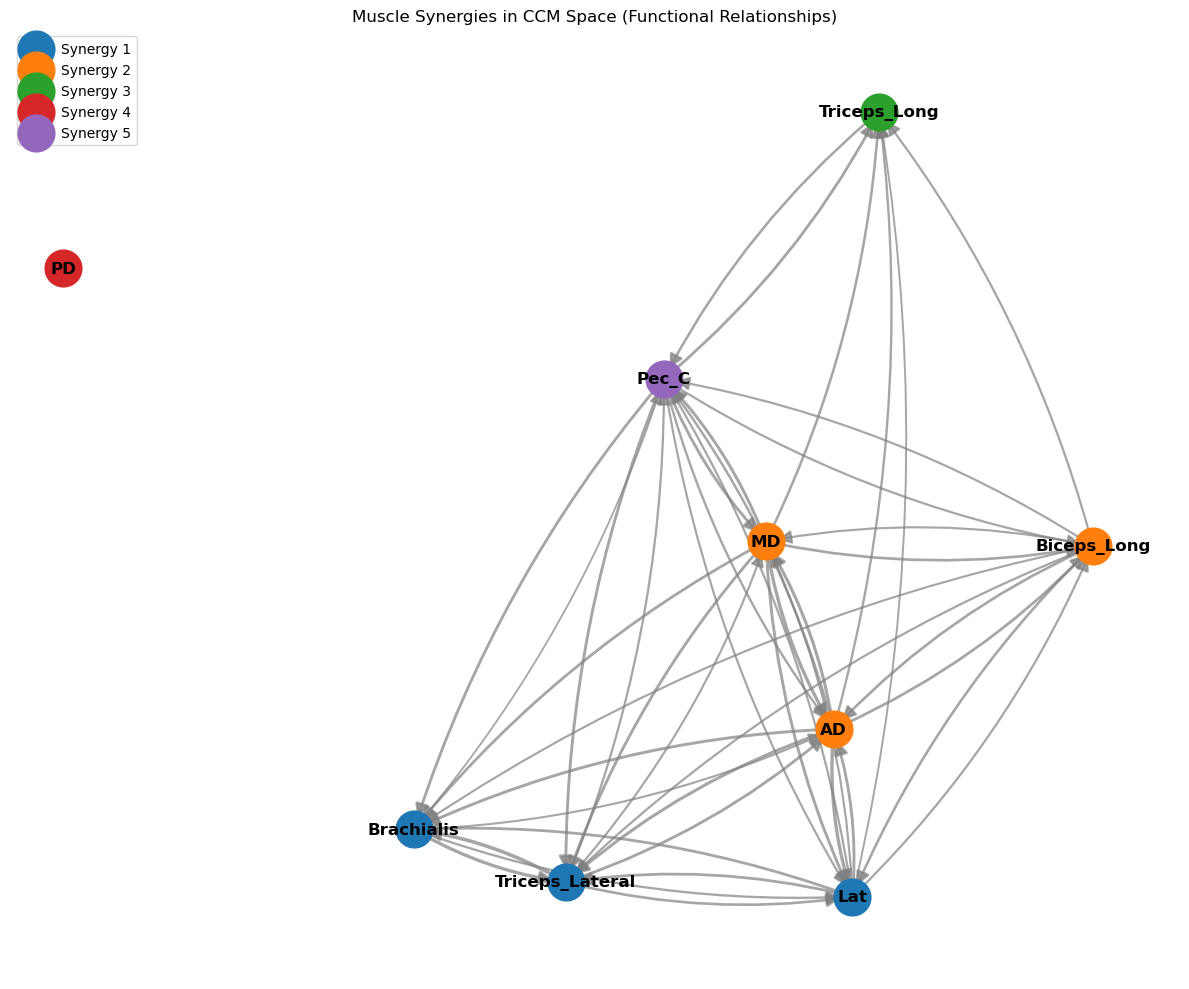

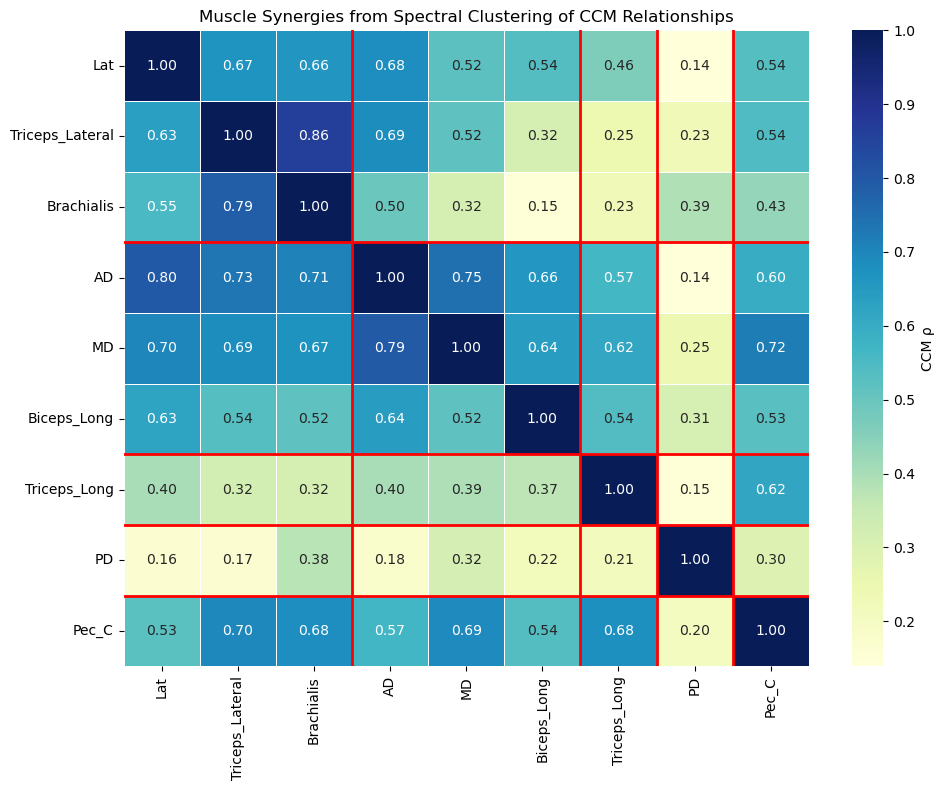

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# Handle any remaining NaN values by replacing with zeros
ccm_matrix = np.nan_to_num(ccm_df.values)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_matrix

# Apply spectral clustering
n_clusters = 5  # Can be adjusted based on domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Display muscle synergy groups
print("Spectral clustering muscle synergies:")
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# === Create graph from CCM matrix ===
G = nx.DiGraph()
for muscle in ccm_df.index:
    G.add_node(muscle)

# Add edges with weights for strong causal connections
for i, source in enumerate(ccm_df.index):
    for j, target in enumerate(ccm_df.columns):
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]) and ccm_df.iloc[i, j] > 0.4:
                G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# === Create a distance matrix for MDS positioning ===
# Convert to a distance matrix where stronger CCM = closer distance
# We create a symmetrized version for positioning (average of both directions)
distance_matrix = np.zeros_like(ccm_matrix)
for i in range(len(ccm_df)):
    for j in range(len(ccm_df)):
        if i != j:
            # Use average of bidirectional values, transform to distance (1 - avg_ccm)
            avg_ccm = (ccm_matrix[i, j] + ccm_matrix[j, i]) / 2
            distance_matrix[i, j] = 1 - avg_ccm

# Use MDS to project the CCM relationships to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distance_matrix)

# Create positions dictionary for networkx
pos_ccm = {muscle: (positions[i,0], positions[i,1]) 
           for i, muscle in enumerate(ccm_df.index)}

# === Visualize the causal network in CCM space ===
plt.figure(figsize=(12, 10))

# Draw nodes colored by cluster
for cluster in range(1, n_clusters+1):
    nodes = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    nx.draw_networkx_nodes(G, pos_ccm, nodelist=nodes, 
                          node_size=700,
                          node_color=f"C{cluster-1}", 
                          label=f"Synergy {cluster}")

# Draw edges with width proportional to CCM strength and arrows for directionality
edges = G.edges(data=True)
weights = [d['weight']*3 for _, _, d in edges]  # Wider lines for visibility
nx.draw_networkx_edges(G, pos_ccm, width=weights, alpha=0.7, 
                      arrowsize=20, edge_color='gray',
                      connectionstyle='arc3,rad=0.1')  # Curved edges for clarity

# Add labels
nx.draw_networkx_labels(G, pos_ccm, font_size=12, font_weight='bold')

plt.title("Muscle Synergies in CCM Space (Functional Relationships)")
plt.legend(loc="upper left")
plt.axis('off')
plt.tight_layout()
plt.savefig("ccm_space_muscle_synergies.png", dpi=300)
plt.show()

# === Create a reordered matrix visualization ===
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Spectral Clustering of CCM Relationships')
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Spectral clustering muscle synergies:
Synergy 1: Lat, Triceps_Lateral, Brachialis
Synergy 2: AD, MD, Biceps_Long
Synergy 3: Triceps_Long
Synergy 4: PD
Synergy 5: Pec_C


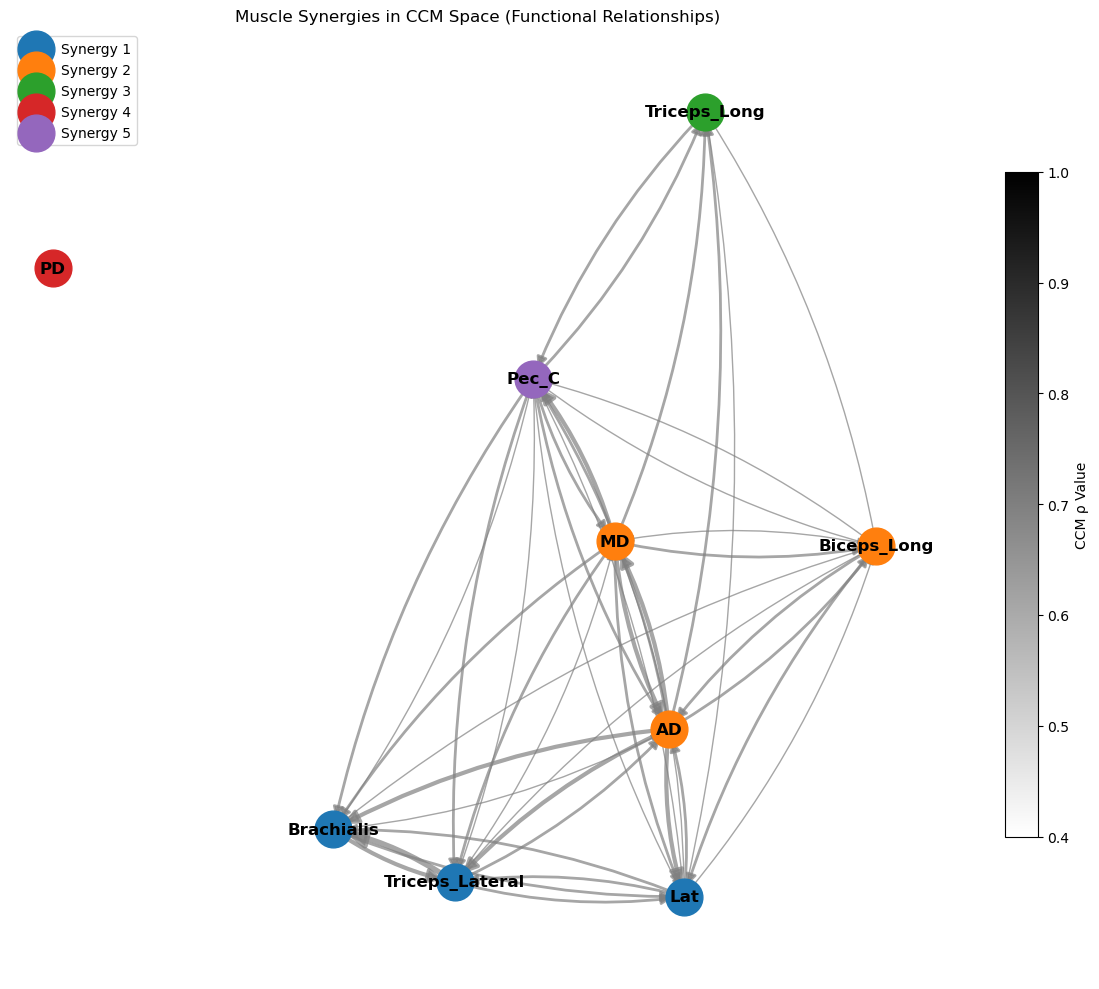

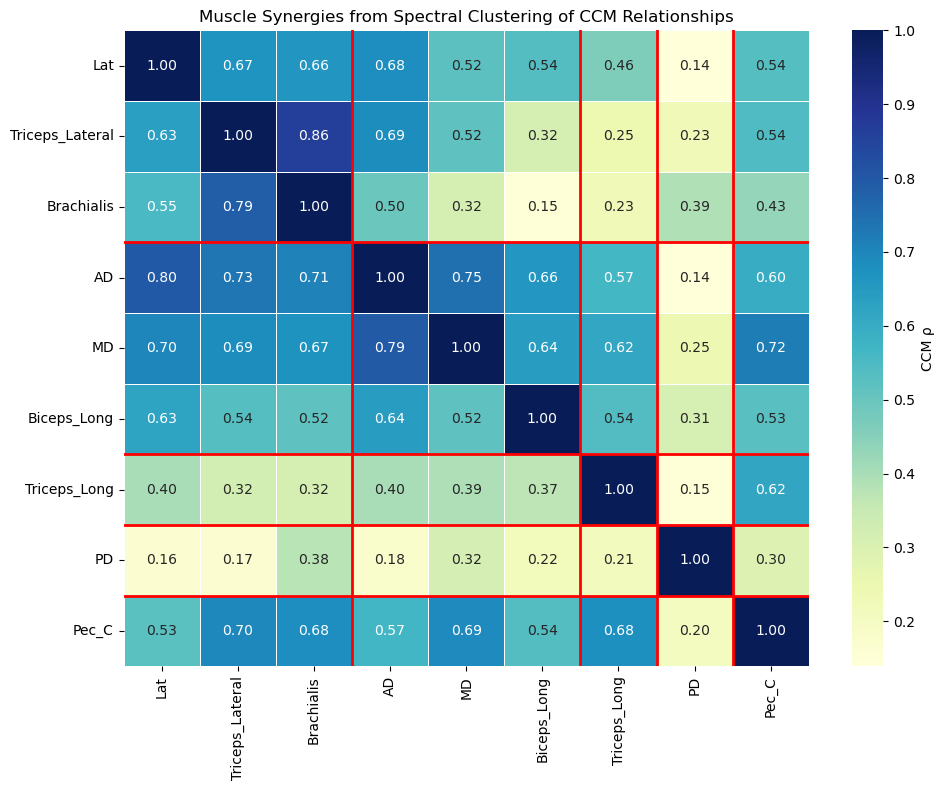

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# Handle any remaining NaN values by replacing with zeros
ccm_matrix = np.nan_to_num(ccm_df.values)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_matrix

# Apply spectral clustering
n_clusters = 5  # Can be adjusted based on domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Display muscle synergy groups
print("Spectral clustering muscle synergies:")
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# === Create graph from CCM matrix ===
G = nx.DiGraph()
for muscle in ccm_df.index:
    G.add_node(muscle)

# Add edges with weights for strong causal connections
for i, source in enumerate(ccm_df.index):
    for j, target in enumerate(ccm_df.columns):
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]) and ccm_df.iloc[i, j] > 0.4:
                G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# === Create a distance matrix for MDS positioning ===
# Convert to a distance matrix where stronger CCM = closer distance
# We create a symmetrized version for positioning (average of both directions)
distance_matrix = np.zeros_like(ccm_matrix)
for i in range(len(ccm_df)):
    for j in range(len(ccm_df)):
        if i != j:
            # Use average of bidirectional values, transform to distance (1 - avg_ccm)
            avg_ccm = (ccm_matrix[i, j] + ccm_matrix[j, i]) / 2
            distance_matrix[i, j] = 1 - avg_ccm

# Use MDS to project the CCM relationships to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distance_matrix)

# Create positions dictionary for networkx
pos_ccm = {muscle: (positions[i,0], positions[i,1]) 
           for i, muscle in enumerate(ccm_df.index)}

# === Visualize the causal network in CCM space ===
plt.figure(figsize=(12, 10))

# Draw nodes colored by cluster
for cluster in range(1, n_clusters+1):
    nodes = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    nx.draw_networkx_nodes(G, pos_ccm, nodelist=nodes, 
                          node_size=700,
                          node_color=f"C{cluster-1}", 
                          label=f"Synergy {cluster}")

# Group edges by weight ranges for better visualization
edges = list(G.edges(data=True))
edges.sort(key=lambda x: x[2]['weight'])  # Sort by weight

# Draw edges with both width and arrow size proportional to CCM strength
# Draw edges in multiple passes grouped by weight
weight_ranges = [
    (0.4, 0.55, 1, 10),   # (min_weight, max_weight, line_width, arrow_size)
    (0.55, 0.7, 2, 15),
    (0.7, 0.85, 3, 20),
    (0.85, 1.01, 4, 30)   # Upper bound slightly over 1.0 to include 1.0
]

for min_w, max_w, width, arrow_size in weight_ranges:
    # Filter edges in this weight range
    range_edges = [(u, v) for u, v, d in edges if min_w <= d['weight'] < max_w]
    
    if range_edges:  # Only draw if there are edges in this range
        nx.draw_networkx_edges(G, pos_ccm, 
                              edgelist=range_edges,
                              width=width, 
                              alpha=0.7,
                              arrowsize=arrow_size, 
                              edge_color=f'gray',
                              connectionstyle='arc3,rad=0.1')

# Add labels
nx.draw_networkx_labels(G, pos_ccm, font_size=12, font_weight='bold')

# Add colorbar legend for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.binary, 
                          norm=plt.Normalize(vmin=0.4, vmax=1.0))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.7)
cbar.set_label('CCM ρ Value')

plt.title("Muscle Synergies in CCM Space (Functional Relationships)")
plt.legend(loc="upper left")
plt.axis('off')
plt.tight_layout()
plt.savefig("ccm_space_muscle_synergies.png", dpi=300)
plt.show()

# === Create a reordered matrix visualization ===
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Spectral Clustering of CCM Relationships')
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Spectral clustering muscle synergies:
Synergy 1: Lat, Triceps_Lateral, Brachialis
Synergy 2: AD, MD, Biceps_Long
Synergy 3: Triceps_Long
Synergy 4: PD
Synergy 5: Pec_C


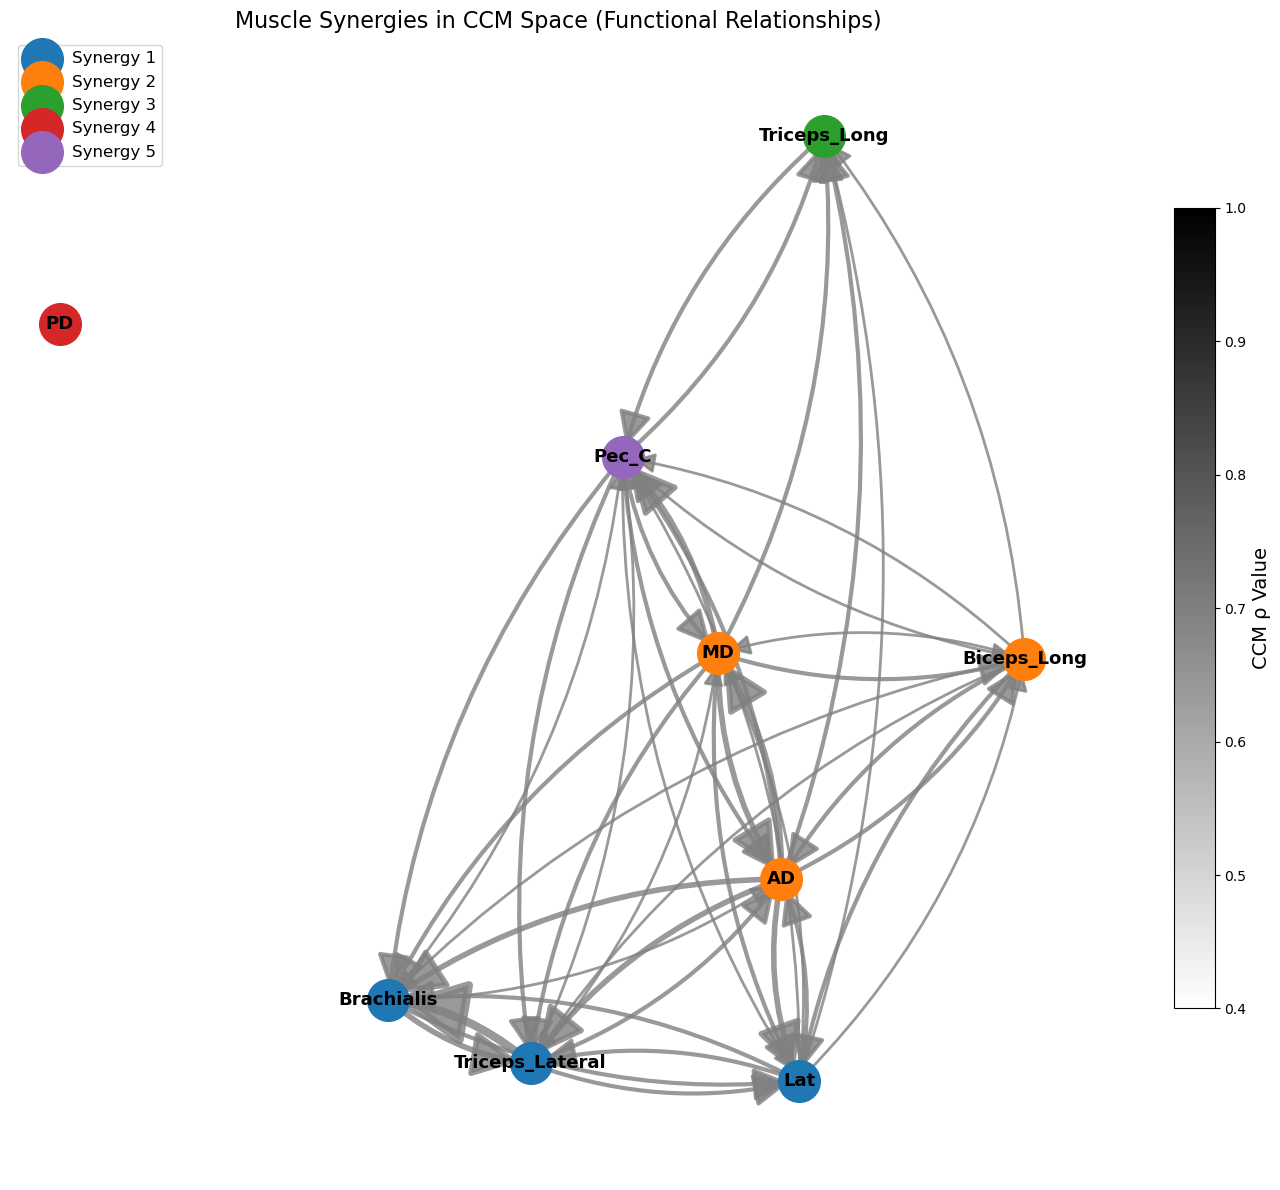

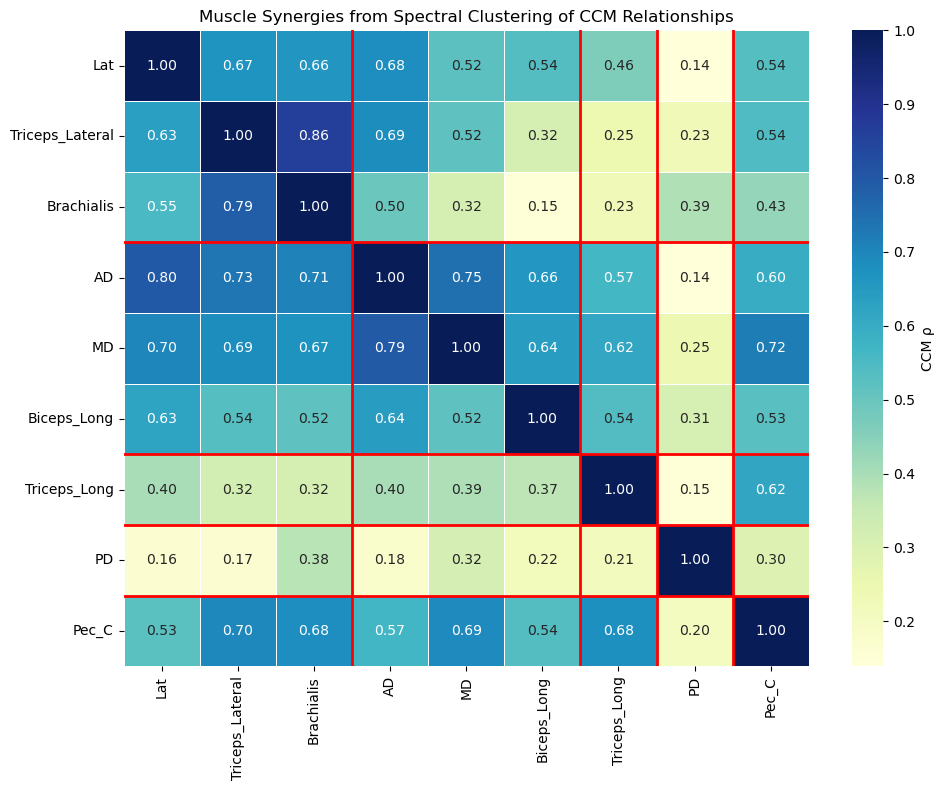

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# Handle any remaining NaN values by replacing with zeros
ccm_matrix = np.nan_to_num(ccm_df.values)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_matrix

# Apply spectral clustering
n_clusters = 5  # Can be adjusted based on domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Display muscle synergy groups
print("Spectral clustering muscle synergies:")
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# === Create graph from CCM matrix ===
G = nx.DiGraph()
for muscle in ccm_df.index:
    G.add_node(muscle)

# Add edges with weights for strong causal connections
for i, source in enumerate(ccm_df.index):
    for j, target in enumerate(ccm_df.columns):
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]) and ccm_df.iloc[i, j] > 0.4:
                G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# === Create a distance matrix for MDS positioning ===
# Convert to a distance matrix where stronger CCM = closer distance
# We create a symmetrized version for positioning (average of both directions)
distance_matrix = np.zeros_like(ccm_matrix)
for i in range(len(ccm_df)):
    for j in range(len(ccm_df)):
        if i != j:
            # Use average of bidirectional values, transform to distance (1 - avg_ccm)
            avg_ccm = (ccm_matrix[i, j] + ccm_matrix[j, i]) / 2
            distance_matrix[i, j] = 1 - avg_ccm

# Use MDS to project the CCM relationships to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distance_matrix)

# Create positions dictionary for networkx
pos_ccm = {muscle: (positions[i,0], positions[i,1]) 
           for i, muscle in enumerate(ccm_df.index)}

# === Visualize the causal network in CCM space ===
plt.figure(figsize=(14, 12))  # Slightly larger figure

# Draw nodes colored by cluster
for cluster in range(1, n_clusters+1):
    nodes = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    nx.draw_networkx_nodes(G, pos_ccm, nodelist=nodes, 
                          node_size=900,  # Increased from 700
                          node_color=f"C{cluster-1}", 
                          label=f"Synergy {cluster}")

# Group edges by weight ranges for better visualization
edges = list(G.edges(data=True))
edges.sort(key=lambda x: x[2]['weight'])  # Sort by weight

# DRAMATICALLY INCREASED ARROW SIZES - weight ranges
weight_ranges = [
    (0.4, 0.55, 2, 30),   # (min_weight, max_weight, line_width, arrow_size) 
    (0.55, 0.7, 3, 50),   # Increased arrow sizes by 3-4x
    (0.7, 0.85, 4, 70),
    (0.85, 1.01, 6, 100)  # Very large arrows for strongest connections
]

# Draw edges with different passes for each weight range
for min_w, max_w, width, arrow_size in weight_ranges:
    # Filter edges in this weight range
    range_edges = [(u, v) for u, v, d in edges if min_w <= d['weight'] < max_w]
    
    if range_edges:  # Only draw if there are edges in this range
        nx.draw_networkx_edges(G, pos_ccm, 
                              edgelist=range_edges,
                              width=width, 
                              alpha=0.8,  # Slightly more opaque
                              arrowsize=arrow_size,  # MUCH larger arrows
                              edge_color='gray',
                              connectionstyle='arc3,rad=0.15')  # Slightly more curved

# Add labels - slightly bigger font
nx.draw_networkx_labels(G, pos_ccm, font_size=13, font_weight='bold')

# Add colorbar legend for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.binary, 
                          norm=plt.Normalize(vmin=0.4, vmax=1.0))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.7)
cbar.set_label('CCM ρ Value', fontsize=14)

plt.title("Muscle Synergies in CCM Space (Functional Relationships)", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.savefig("ccm_space_muscle_synergies_big_arrows.png", dpi=300)
plt.show()

# === Create a reordered matrix visualization ===
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Spectral Clustering of CCM Relationships')
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Spectral clustering muscle synergies:
Synergy 1: Lat, Triceps_Lateral, Brachialis
Synergy 2: AD, MD, Biceps_Long
Synergy 3: Triceps_Long
Synergy 4: PD
Synergy 5: Pec_C
Number of edges to draw: 42
Edges in weight range 0.5-0.65: 22
Added arrow from Triceps_Lateral to MD with weight 0.52
Added arrow from Biceps_Long to MD with weight 0.52
Added arrow from Biceps_Long to Brachialis with weight 0.52
Added arrow from Lat to MD with weight 0.52
Added arrow from Pec_C to Lat with weight 0.53
Added arrow from Biceps_Long to Pec_C with weight 0.53
Added arrow from Lat to Pec_C with weight 0.54
Added arrow from Biceps_Long to Triceps_Lateral with weight 0.54
Added arrow from Pec_C to Biceps_Long with weight 0.54
Added arrow from Lat to Biceps_Long with weight 0.54
Added arrow from Biceps_Long to Triceps_Long with weight 0.54
Added arrow from Triceps_Lateral to Pec_C with weight 0.54
Added arrow from Brachialis to Lat with weight 0.55
Added arrow from AD to Triceps_Long with weight 0.57
Added arr

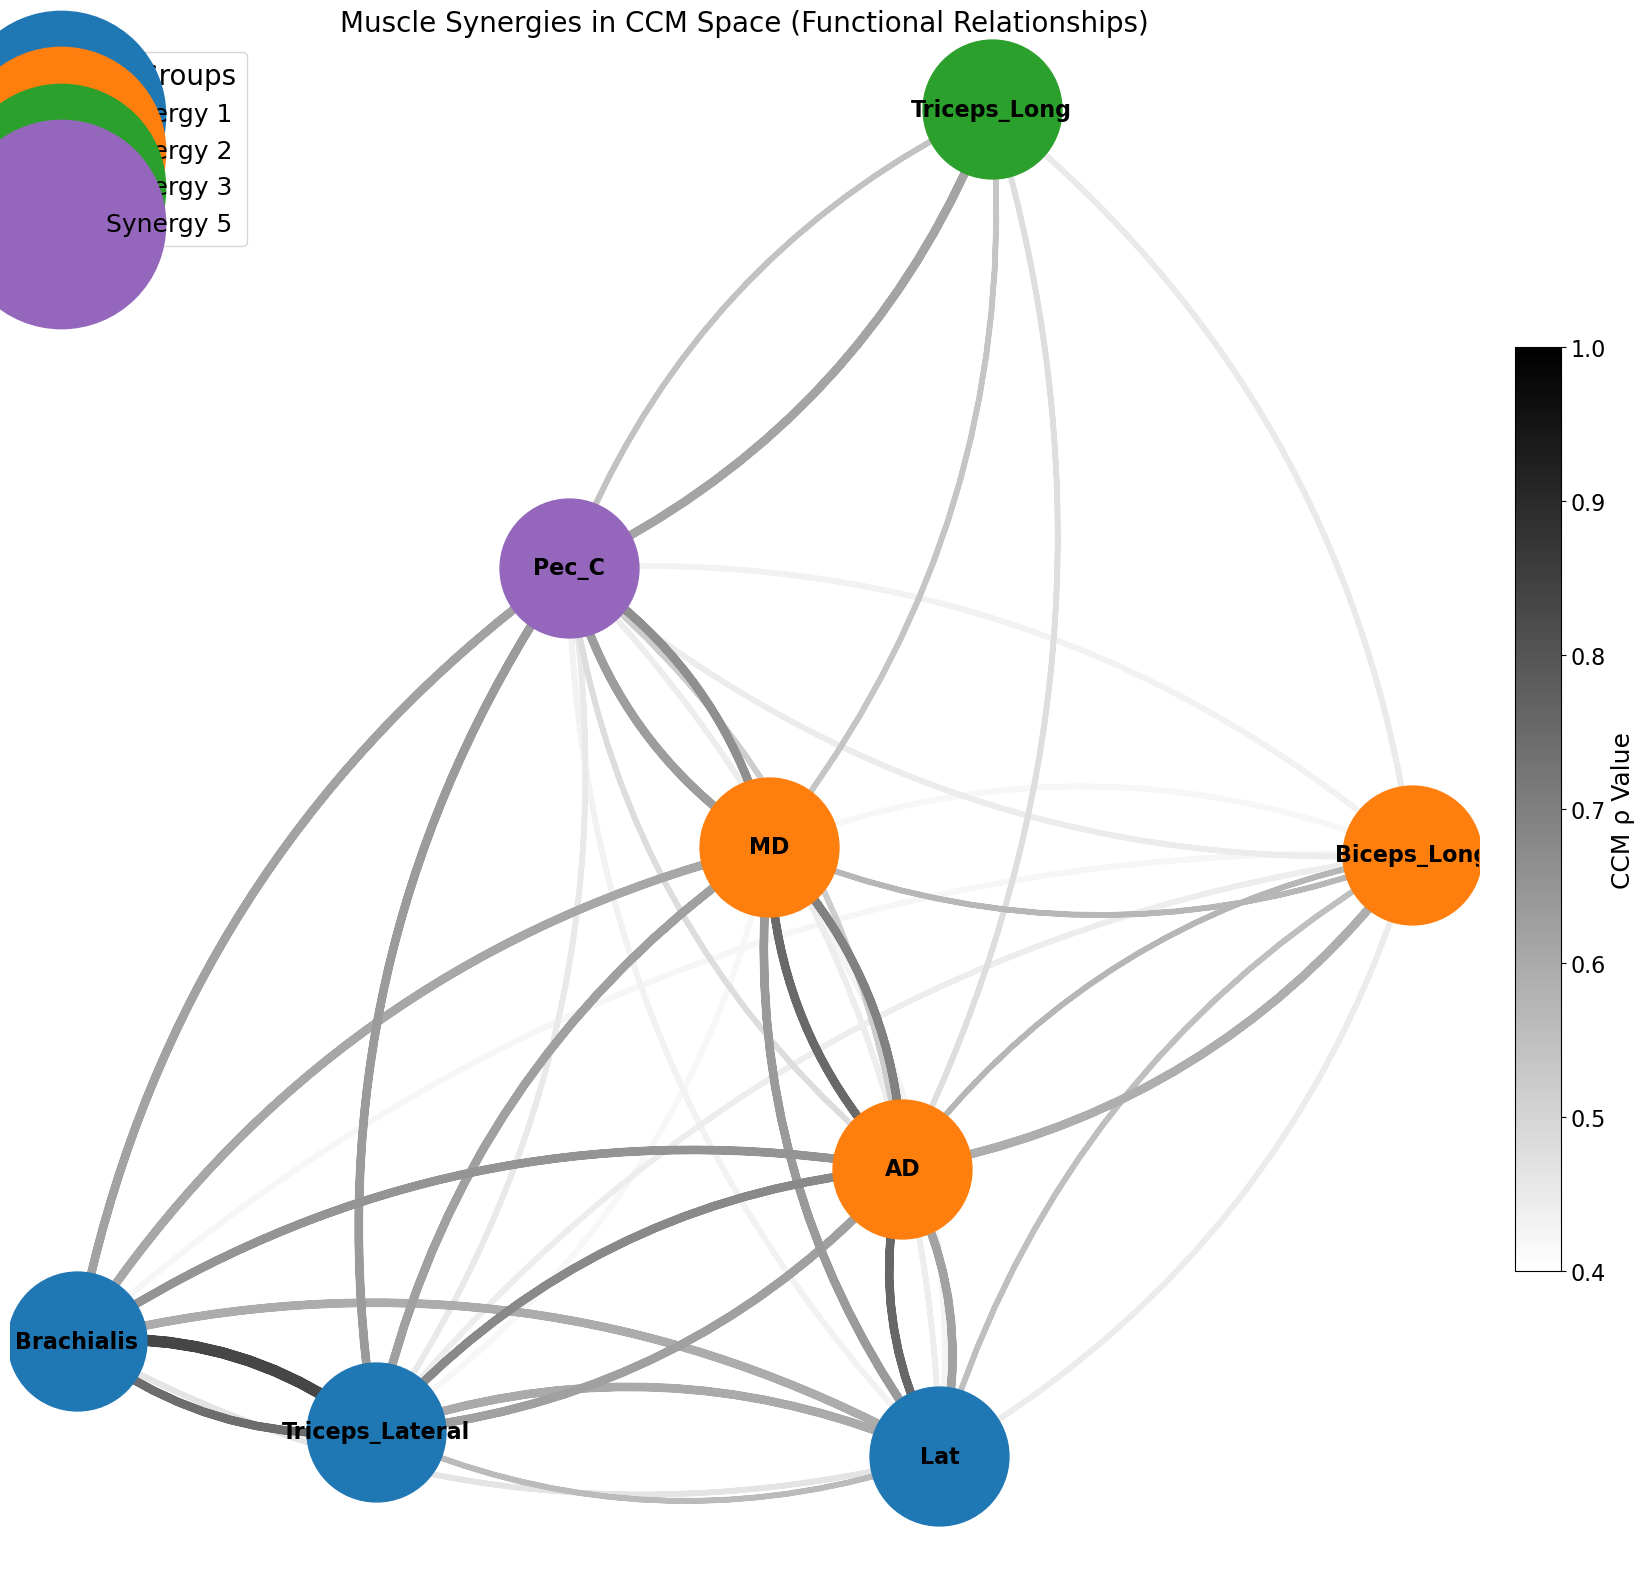

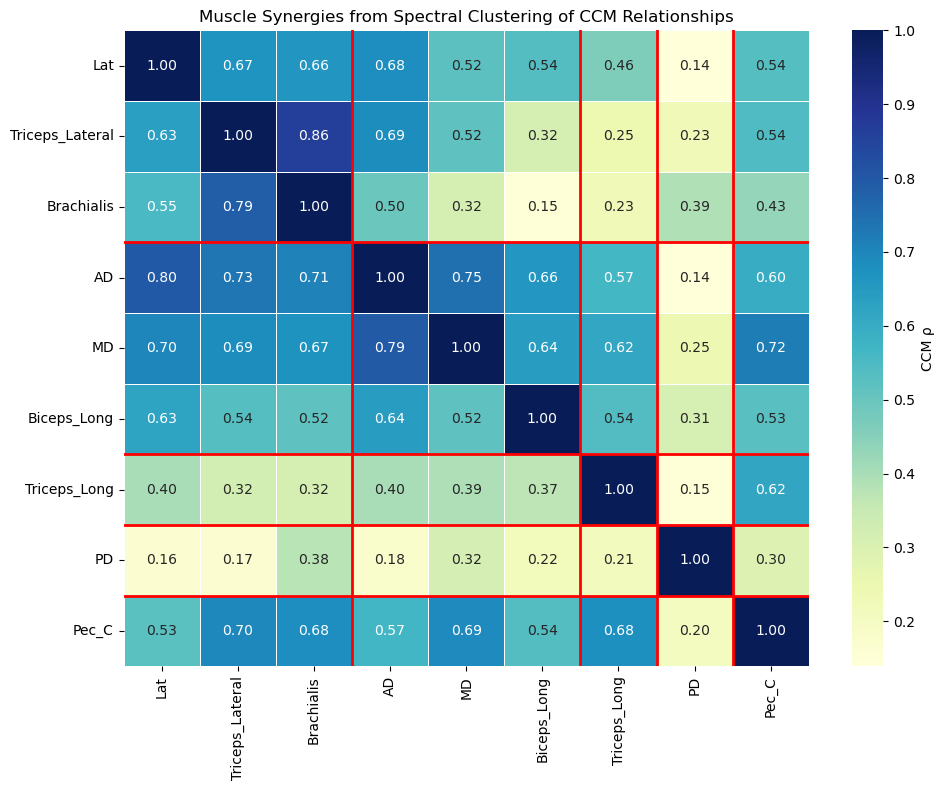

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import math
from matplotlib.colors import Normalize

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# Handle any remaining NaN values by replacing with zeros
ccm_matrix = np.nan_to_num(ccm_df.values)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_matrix

# Apply spectral clustering
n_clusters = 5  # Can be adjusted based on domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Display muscle synergy groups
print("Spectral clustering muscle synergies:")
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# === Create graph from CCM matrix ===
G = nx.DiGraph()
for muscle in ccm_df.index:
    # Skip adding PD to the graph
    if muscle != "PD":
        G.add_node(muscle)

# Add edges with weights for strong causal connections - INCREASED THRESHOLD TO 0.5
for i, source in enumerate(ccm_df.index):
    if source == "PD":  # Skip PD as source
        continue
    for j, target in enumerate(ccm_df.columns):
        if target == "PD":  # Skip PD as target
            continue
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]) and ccm_df.iloc[i, j] >= 0.5:  # Changed from > 0.4 to >= 0.5
                G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# === Create a distance matrix for MDS positioning ===
# We'll keep PD in the analysis but just not display it
distance_matrix = np.zeros_like(ccm_matrix)
for i in range(len(ccm_df)):
    for j in range(len(ccm_df)):
        if i != j:
            # Use average of bidirectional values, transform to distance (1 - avg_ccm)
            avg_ccm = (ccm_matrix[i, j] + ccm_matrix[j, i]) / 2
            distance_matrix[i, j] = 1 - avg_ccm

# Use MDS to project the CCM relationships to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distance_matrix)

# Create positions dictionary for networkx (excluding PD)
pos_ccm = {}
for i, muscle in enumerate(ccm_df.index):
    if muscle != "PD":  # Skip PD
        pos_ccm[muscle] = (positions[i,0], positions[i,1])

# === Visualize the causal network in CCM space ===
fig, ax = plt.subplots(figsize=(18, 16))  # Even larger figure for better spacing

# Define node size - needed for arrow calculations
node_size = 10000

# Draw nodes colored by cluster - MUCH larger nodes
for cluster in range(1, n_clusters+1):
    nodes = [m for m in muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist() if m != "PD"]
    if nodes:  # Only draw if there are nodes in this cluster after filtering PD
        nx.draw_networkx_nodes(G, pos_ccm, nodelist=nodes, 
                              node_size=node_size,
                              node_color=f"C{cluster-1}", 
                              label=f"Synergy {cluster}",
                              ax=ax)

# Group edges by weight ranges for better visualization
edges = list(G.edges(data=True))
edges.sort(key=lambda x: x[2]['weight'])  # Sort by weight

# DRAMATICALLY INCREASED ARROW SIZES - weight ranges (adjusted for minimum 0.5)
weight_ranges = [
    (0.5, 0.65, 4, 30),   # (min_weight, max_weight, line_width, arrow_size)
    (0.65, 0.8, 6, 50),   # Adjusted ranges for threshold of 0.5
    (0.8, 0.9, 8, 70),
    (0.9, 1.01, 10, 100)  # Very large arrows for strongest connections
]

# Calculate node radius for arrow positioning
node_radius = math.sqrt(node_size) * 0.35  # Adjusted for better positioning

# Create color normalization for edge weights
norm = Normalize(vmin=0.5, vmax=1.0)  # Normalize from 0.5 to 1.0
cmap = plt.cm.binary  # Use the binary colormap

print(f"Number of edges to draw: {len(edges)}")  # Debug info

# Draw edges with different passes for each weight range - with proper edge connection
for min_w, max_w, width, arrow_size in weight_ranges:
    # Filter edges in this weight range
    range_edges = [(u, v, d) for u, v, d in edges if min_w <= d['weight'] < max_w]
    
    print(f"Edges in weight range {min_w}-{max_w}: {len(range_edges)}")  # Debug info
    
    if range_edges:  # Only draw if there are edges in this range
        for u, v, d in range_edges:
            # Get positions
            pos_u = pos_ccm[u]
            pos_v = pos_ccm[v]
            
            # Get color based on edge weight
            edge_color = cmap(norm(d['weight']))
            
            # Create a FancyArrowPatch with shrinkage to stop at node boundaries
            arrow = mpatches.FancyArrowPatch(
                pos_u, pos_v,
                connectionstyle='arc3,rad=0.2',  # Increased curvature for visibility
                arrowstyle=f'simple,head_length={arrow_size*0.015},head_width={arrow_size*0.015}',
                linewidth=width,
                color=edge_color,  # Use color based on weight
                alpha=1.0,  # Full opacity
                shrinkA=node_radius,  # Shrink from start node
                shrinkB=node_radius,  # Shrink to end node
                zorder=0  # Ensure arrows appear behind nodes
            )
            
            ax.add_patch(arrow)
            print(f"Added arrow from {u} to {v} with weight {d['weight']:.2f}")  # Debug info

# Add labels - bigger font to match larger nodes
nx.draw_networkx_labels(G, pos_ccm, font_size=16, font_weight='bold', ax=ax)

# Add colorbar legend for edge weights - Changed range to 0.5-1.0
sm = plt.cm.ScalarMappable(cmap=plt.cm.binary, 
                          norm=plt.Normalize(vmin=0.4, vmax=1.0))  # Match actual displayed range
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('CCM ρ Value', fontsize=18)
cbar.ax.tick_params(labelsize=16)  # Make colorbar tick labels larger

# Create MUCH larger legend
plt.title("Muscle Synergies in CCM Space (Functional Relationships)", fontsize=20)
legend = plt.legend(loc="upper left", fontsize=18, markerscale=1.5, title="Muscle Groups", frameon=True)
legend.get_title().set_fontsize(20)  # Make legend title larger

# Add more margin to prevent cutoff
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.axis('off')
plt.tight_layout()
plt.savefig("ccm_space_muscle_synergies_big_arrows.png", dpi=300)
plt.show()

# === Create a reordered matrix visualization ===
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Spectral Clustering of CCM Relationships')
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Spectral clustering muscle synergies:
Synergy 1: Lat, Triceps_Lateral, Brachialis
Synergy 2: AD, MD, Biceps_Long
Synergy 3: Triceps_Long
Synergy 4: PD
Synergy 5: Pec_C
Number of edges to draw: 42
Edges in weight range 0.5-0.65: 22
Added arrow from Triceps_Lateral to MD with weight 0.52
Added arrow from Biceps_Long to MD with weight 0.52
Added arrow from Biceps_Long to Brachialis with weight 0.52
Added arrow from Lat to MD with weight 0.52
Added arrow from Pec_C to Lat with weight 0.53
Added arrow from Biceps_Long to Pec_C with weight 0.53
Added arrow from Lat to Pec_C with weight 0.54
Added arrow from Biceps_Long to Triceps_Lateral with weight 0.54
Added arrow from Pec_C to Biceps_Long with weight 0.54
Added arrow from Lat to Biceps_Long with weight 0.54
Added arrow from Biceps_Long to Triceps_Long with weight 0.54
Added arrow from Triceps_Lateral to Pec_C with weight 0.54
Added arrow from Brachialis to Lat with weight 0.55
Added arrow from AD to Triceps_Long with weight 0.57
Added arr

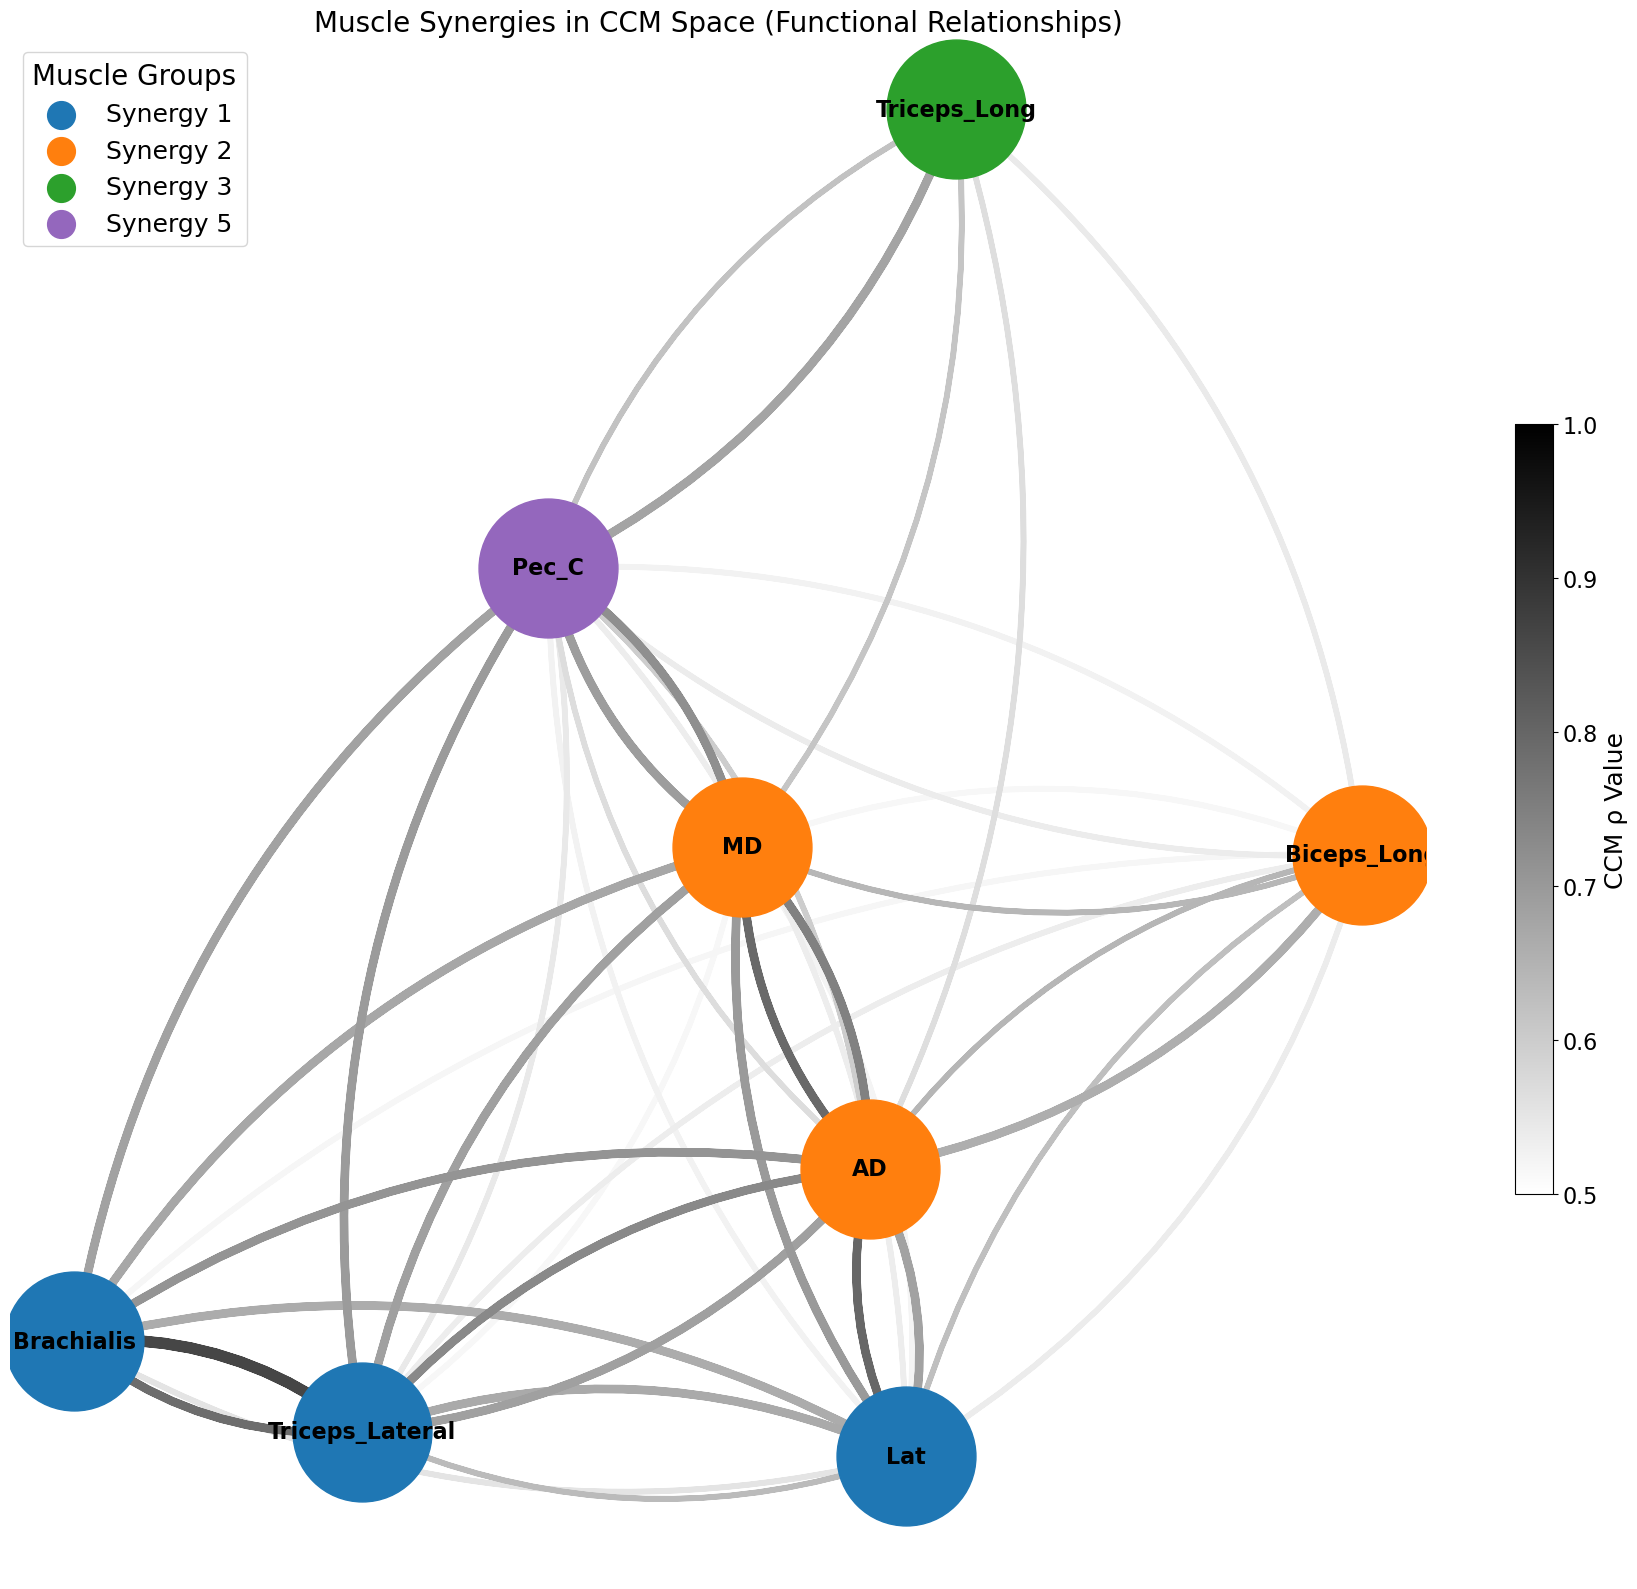

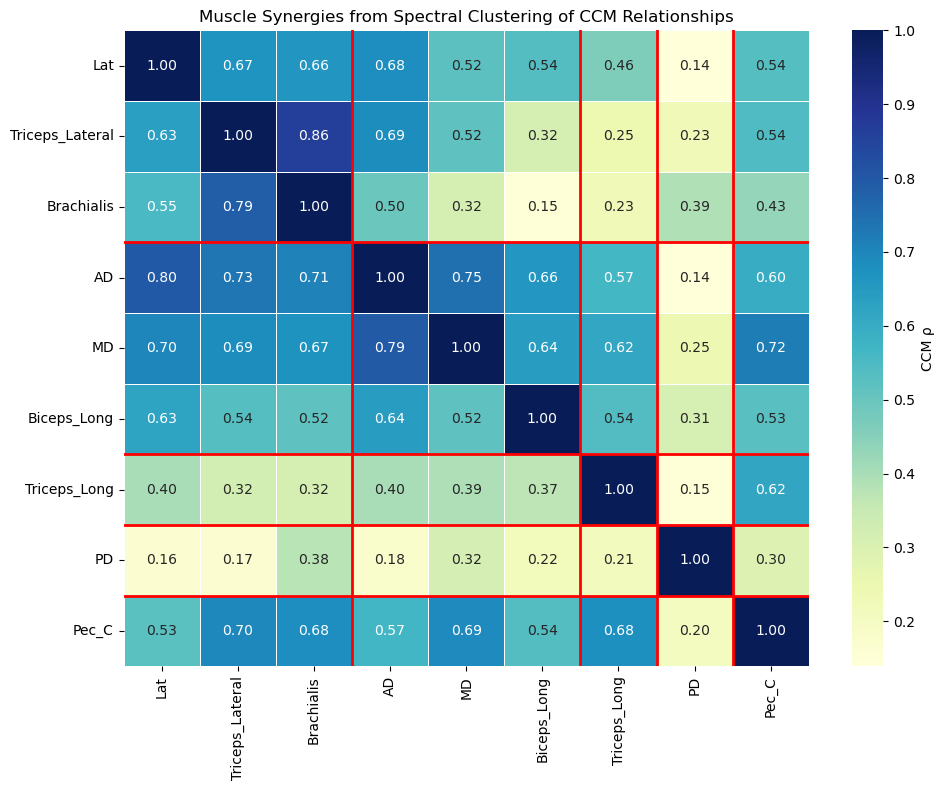

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import math
from matplotlib.colors import Normalize

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# Handle any remaining NaN values by replacing with zeros
ccm_matrix = np.nan_to_num(ccm_df.values)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_matrix

# Apply spectral clustering
n_clusters = 5  # Can be adjusted based on domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Display muscle synergy groups
print("Spectral clustering muscle synergies:")
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# === Create graph from CCM matrix ===
G = nx.DiGraph()
for muscle in ccm_df.index:
    # Skip adding PD to the graph
    if muscle != "PD":
        G.add_node(muscle)

# Add edges with weights for strong causal connections - INCREASED THRESHOLD TO 0.5
for i, source in enumerate(ccm_df.index):
    if source == "PD":  # Skip PD as source
        continue
    for j, target in enumerate(ccm_df.columns):
        if target == "PD":  # Skip PD as target
            continue
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]) and ccm_df.iloc[i, j] >= 0.5:  # Changed from > 0.4 to >= 0.5
                G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# === Create a distance matrix for MDS positioning ===
# We'll keep PD in the analysis but just not display it
distance_matrix = np.zeros_like(ccm_matrix)
for i in range(len(ccm_df)):
    for j in range(len(ccm_df)):
        if i != j:
            # Use average of bidirectional values, transform to distance (1 - avg_ccm)
            avg_ccm = (ccm_matrix[i, j] + ccm_matrix[j, i]) / 2
            distance_matrix[i, j] = 1 - avg_ccm

# Use MDS to project the CCM relationships to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distance_matrix)

# Create positions dictionary for networkx (excluding PD)
pos_ccm = {}
for i, muscle in enumerate(ccm_df.index):
    if muscle != "PD":  # Skip PD
        pos_ccm[muscle] = (positions[i,0], positions[i,1])

# === Visualize the causal network in CCM space ===
fig, ax = plt.subplots(figsize=(18, 16))  # Even larger figure for better spacing

# Define node size - needed for arrow calculations
node_size = 10000

# Draw nodes colored by cluster - MUCH larger nodes
for cluster in range(1, n_clusters+1):
    nodes = [m for m in muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist() if m != "PD"]
    if nodes:  # Only draw if there are nodes in this cluster after filtering PD
        nx.draw_networkx_nodes(G, pos_ccm, nodelist=nodes, 
                              node_size=node_size,
                              node_color=f"C{cluster-1}", 
                              label=f"Synergy {cluster}",
                              ax=ax)

# Group edges by weight ranges for better visualization
edges = list(G.edges(data=True))
edges.sort(key=lambda x: x[2]['weight'])  # Sort by weight

# DRAMATICALLY INCREASED ARROW SIZES - weight ranges (adjusted for minimum 0.5)
weight_ranges = [
    (0.5, 0.65, 4, 30),   # (min_weight, max_weight, line_width, arrow_size)
    (0.65, 0.8, 6, 50),   # Adjusted ranges for threshold of 0.5
    (0.8, 0.9, 8, 70),
    (0.9, 1.01, 10, 100)  # Very large arrows for strongest connections
]

# Calculate node radius for arrow positioning
node_radius = math.sqrt(node_size) * 0.35  # Adjusted for better positioning

# Create color normalization for edge weights
norm = Normalize(vmin=0.5, vmax=1.0)  # Normalize from 0.5 to 1.0
cmap = plt.cm.binary  # Use the binary colormap

print(f"Number of edges to draw: {len(edges)}")  # Debug info

# Draw edges with different passes for each weight range - with proper edge connection
for min_w, max_w, width, arrow_size in weight_ranges:
    # Filter edges in this weight range
    range_edges = [(u, v, d) for u, v, d in edges if min_w <= d['weight'] < max_w]
    
    print(f"Edges in weight range {min_w}-{max_w}: {len(range_edges)}")  # Debug info
    
    if range_edges:  # Only draw if there are edges in this range
        for u, v, d in range_edges:
            # Get positions
            pos_u = pos_ccm[u]
            pos_v = pos_ccm[v]
            
            # Get color based on edge weight
            edge_color = cmap(norm(d['weight']))
            
            # Create a FancyArrowPatch with shrinkage to stop at node boundaries
            arrow = mpatches.FancyArrowPatch(
                pos_u, pos_v,
                connectionstyle='arc3,rad=0.2',  # Increased curvature for visibility
                arrowstyle=f'simple,head_length={arrow_size*0.015},head_width={arrow_size*0.015}',
                linewidth=width,
                color=edge_color,  # Use color based on weight
                alpha=1.0,  # Full opacity
                shrinkA=node_radius,  # Shrink from start node
                shrinkB=node_radius,  # Shrink to end node
                zorder=0  # Ensure arrows appear behind nodes
            )
            
            ax.add_patch(arrow)
            print(f"Added arrow from {u} to {v} with weight {d['weight']:.2f}")  # Debug info

# Add labels - bigger font to match larger nodes
nx.draw_networkx_labels(G, pos_ccm, font_size=16, font_weight='bold', ax=ax)

# Add colorbar legend for edge weights - Changed range to 0.5-1.0 and moved to right
sm = plt.cm.ScalarMappable(cmap=plt.cm.binary, 
                          norm=plt.Normalize(vmin=0.5, vmax=1.0))  # Match actual displayed range
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.05)  # Increased padding, reduced size
cbar.set_label('CCM ρ Value', fontsize=18)
cbar.ax.tick_params(labelsize=16)  # Make colorbar tick labels larger

# Create legend with smaller nodes
plt.title("Muscle Synergies in CCM Space (Functional Relationships)", fontsize=20)
legend = plt.legend(loc="upper left", fontsize=18, markerscale=0.2, title="Muscle Groups", frameon=True)
legend.get_title().set_fontsize(20)  # Make legend title larger

# Add more margin to prevent cutoff
plt.subplots_adjust(left=0.05, right=0.92, top=0.95, bottom=0.05)  # Increased right margin
plt.axis('off')
plt.tight_layout()
plt.savefig("ccm_space_muscle_synergies_big_arrows.png", dpi=300)
plt.show()

# === Create a reordered matrix visualization ===
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Spectral Clustering of CCM Relationships')
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Spectral clustering muscle synergies:
Synergy 1: Lat, Triceps_Lateral, Brachialis
Synergy 2: AD, MD, Biceps_Long
Synergy 3: Triceps_Long
Synergy 4: PD
Synergy 5: Pec_C
Number of edges to draw: 42
Edges in weight range 0.5-0.65: 22
Added arrow from Triceps_Lateral to MD with weight 0.52
Added arrow from Biceps_Long to MD with weight 0.52
Added arrow from Biceps_Long to Brachialis with weight 0.52
Added arrow from Lat to MD with weight 0.52
Added arrow from Pec_C to Lat with weight 0.53
Added arrow from Biceps_Long to Pec_C with weight 0.53
Added arrow from Lat to Pec_C with weight 0.54
Added arrow from Biceps_Long to Triceps_Lateral with weight 0.54
Added arrow from Pec_C to Biceps_Long with weight 0.54
Added arrow from Lat to Biceps_Long with weight 0.54
Added arrow from Biceps_Long to Triceps_Long with weight 0.54
Added arrow from Triceps_Lateral to Pec_C with weight 0.54
Added arrow from Brachialis to Lat with weight 0.55
Added arrow from AD to Triceps_Long with weight 0.57
Added arr

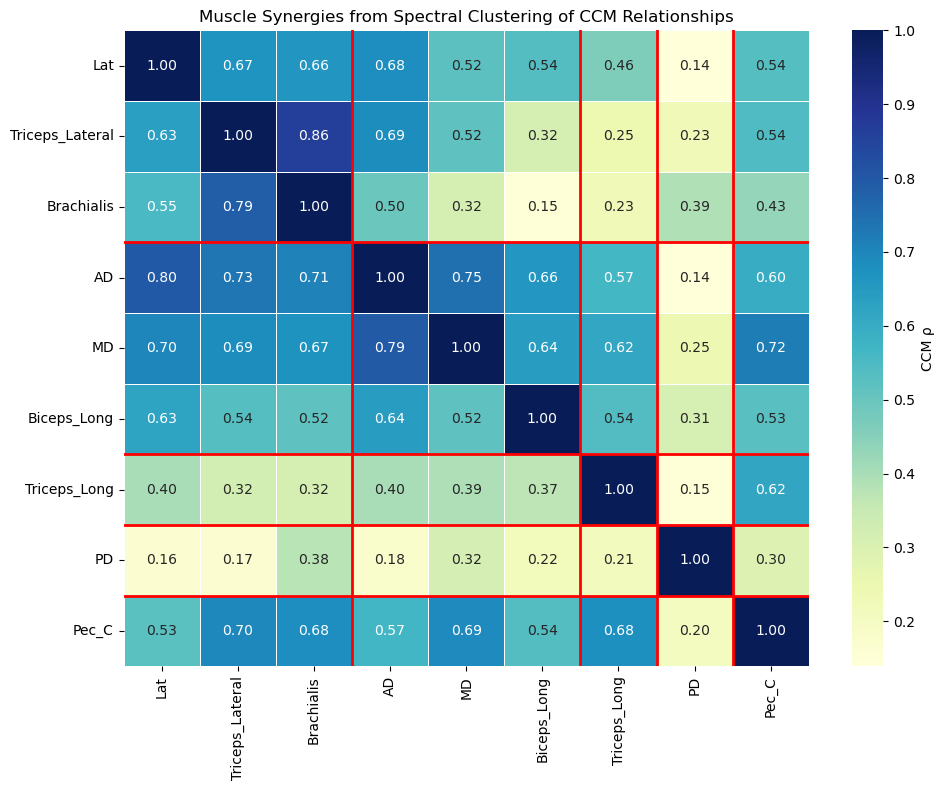

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import math
from matplotlib.colors import Normalize

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# Handle any remaining NaN values by replacing with zeros
ccm_matrix = np.nan_to_num(ccm_df.values)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_matrix

# Apply spectral clustering
n_clusters = 5  # Can be adjusted based on domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Create a dictionary mapping muscle to cluster for easy lookup
muscle_to_cluster = dict(zip(muscle_clusters['Muscle'], muscle_clusters['Cluster']))

# Display muscle synergy groups
print("Spectral clustering muscle synergies:")
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# === Create graph from CCM matrix ===
G = nx.DiGraph()
for muscle in ccm_df.index:
    # Skip adding PD to the graph
    if muscle != "PD":
        G.add_node(muscle)

# Add edges with weights for strong causal connections - INCREASED THRESHOLD TO 0.5
for i, source in enumerate(ccm_df.index):
    if source == "PD":  # Skip PD as source
        continue
    for j, target in enumerate(ccm_df.columns):
        if target == "PD":  # Skip PD as target
            continue
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]) and ccm_df.iloc[i, j] >= 0.5:  # Changed from > 0.4 to >= 0.5
                G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# === Create a distance matrix for MDS positioning ===
# We'll keep PD in the analysis but just not display it
distance_matrix = np.zeros_like(ccm_matrix)
for i in range(len(ccm_df)):
    for j in range(len(ccm_df)):
        if i != j:
            # Use average of bidirectional values, transform to distance (1 - avg_ccm)
            avg_ccm = (ccm_matrix[i, j] + ccm_matrix[j, i]) / 2
            distance_matrix[i, j] = 1 - avg_ccm

# Use MDS to project the CCM relationships to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distance_matrix)

# Create positions dictionary for networkx (excluding PD)
pos_ccm = {}
for i, muscle in enumerate(ccm_df.index):
    if muscle != "PD":  # Skip PD
        pos_ccm[muscle] = (positions[i,0], positions[i,1])

# === Visualize the causal network in CCM space ===
fig, ax = plt.subplots(figsize=(18, 16))  # Even larger figure for better spacing

# Define node size - needed for arrow calculations
node_size = 10000

# Draw nodes colored by cluster - MUCH larger nodes
for cluster in range(1, n_clusters+1):
    nodes = [m for m in muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist() if m != "PD"]
    if nodes:  # Only draw if there are nodes in this cluster after filtering PD
        nx.draw_networkx_nodes(G, pos_ccm, nodelist=nodes, 
                              node_size=node_size,
                              node_color=f"C{cluster-1}", 
                              label=f"Synergy {cluster}",
                              ax=ax)

# Group edges by weight ranges for better visualization
edges = list(G.edges(data=True))
edges.sort(key=lambda x: x[2]['weight'])  # Sort by weight

# DRAMATICALLY INCREASED ARROW SIZES - weight ranges (adjusted for minimum 0.5)
weight_ranges = [
    (0.5, 0.65, 4, 30),   # (min_weight, max_weight, line_width, arrow_size)
    (0.65, 0.8, 6, 50),   # Adjusted ranges for threshold of 0.5
    (0.8, 0.9, 8, 70),
    (0.9, 1.01, 10, 100)  # Very large arrows for strongest connections
]

# Calculate node radius for arrow positioning
node_radius = math.sqrt(node_size) * 0.35  # Adjusted for better positioning

# Create color normalization for edge weights
norm = Normalize(vmin=0.5, vmax=1.0)  # Normalize from 0.5 to 1.0
cmap = plt.cm.binary  # Use the binary colormap

print(f"Number of edges to draw: {len(edges)}")  # Debug info

# Draw edges with different passes for each weight range - with proper edge connection
for min_w, max_w, width, arrow_size in weight_ranges:
    # Filter edges in this weight range
    range_edges = [(u, v, d) for u, v, d in edges if min_w <= d['weight'] < max_w]
    
    print(f"Edges in weight range {min_w}-{max_w}: {len(range_edges)}")  # Debug info
    
    if range_edges:  # Only draw if there are edges in this range
        for u, v, d in range_edges:
            # Get positions
            pos_u = pos_ccm[u]
            pos_v = pos_ccm[v]
            
            # Check if both nodes are in the same synergy/cluster
            if muscle_to_cluster.get(u) == muscle_to_cluster.get(v):
                # Use the cluster color for within-synergy connections
                cluster_num = muscle_to_cluster.get(u)
                edge_color = f"C{cluster_num-1}"  # Same color as the nodes
                alpha = 0.8  # Slightly transparent to see the arrows better
            else:
                # Use weight-based grayscale color for between-synergy connections
                edge_color = cmap(norm(d['weight']))
                alpha = 1.0
            
            # Create a FancyArrowPatch with shrinkage to stop at node boundaries
            arrow = mpatches.FancyArrowPatch(
                pos_u, pos_v,
                connectionstyle='arc3,rad=0.2',  # Increased curvature for visibility
                arrowstyle=f'simple,head_length={arrow_size*0.015},head_width={arrow_size*0.015}',
                linewidth=width,
                color=edge_color,  # Use color based on synergy or weight
                alpha=alpha,  # Adjust opacity
                shrinkA=node_radius,  # Shrink from start node
                shrinkB=node_radius,  # Shrink to end node
                zorder=0  # Ensure arrows appear behind nodes
            )
            
            ax.add_patch(arrow)
            print(f"Added arrow from {u} to {v} with weight {d['weight']:.2f}")  # Debug info

# Add labels - bigger font to match larger nodes
nx.draw_networkx_labels(G, pos_ccm, font_size=18, font_weight='bold', ax=ax)  # Increased from 16 to 18

# Add colorbar legend for edge weights - Changed range to 0.5-1.0 and moved to right
sm = plt.cm.ScalarMappable(cmap=plt.cm.binary, 
                          norm=plt.Normalize(vmin=0.5, vmax=1.0))  # Match actual displayed range
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.08)  # Increased padding for more space
cbar.set_label('CCM ρ Value', fontsize=22)  # Increased from 18 to 22
cbar.ax.tick_params(labelsize=18)  # Increased from 16 to 18

# Create legend with smaller nodes but larger text
plt.title("Muscle Synergies in CCM Space (Functional Relationships)", fontsize=24)  # Increased from 20 to 24
legend = plt.legend(loc="upper left", fontsize=20, markerscale=0.2, title="Muscle Groups", frameon=True)  # Increased from 18 to 20
legend.get_title().set_fontsize(22)  # Increased from 20 to 22

# Add more margin to prevent cutoff
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05)  # Increased right margin from 0.92 to 0.9
plt.axis('off')
plt.tight_layout()
plt.savefig("ccm_space_muscle_synergies_big_arrows.png", dpi=300)
plt.show()

# === Create a reordered matrix visualization ===
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Spectral Clustering of CCM Relationships')
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Spectral clustering muscle synergies:
Synergy 1: Triceps_Lateral, Brachialis
Synergy 2: Lat, Triceps_Long
Synergy 3: AD, MD
Synergy 4: PD
Synergy 5: Biceps_Long
Synergy 6: Pec_C
Number of edges to draw: 42
Edges in weight range 0.5-0.65: 22
Added arrow from Triceps_Lateral to MD with weight 0.52, alpha=0.32
Added arrow from Biceps_Long to MD with weight 0.52, alpha=0.32
Added arrow from Biceps_Long to Brachialis with weight 0.52, alpha=0.33
Added arrow from Lat to MD with weight 0.52, alpha=0.33
Added arrow from Pec_C to Lat with weight 0.53, alpha=0.34
Added arrow from Biceps_Long to Pec_C with weight 0.53, alpha=0.34
Added arrow from Lat to Pec_C with weight 0.54, alpha=0.35
Added arrow from Biceps_Long to Triceps_Lateral with weight 0.54, alpha=0.35
Added arrow from Pec_C to Biceps_Long with weight 0.54, alpha=0.35
Added arrow from Lat to Biceps_Long with weight 0.54, alpha=0.35
Added arrow from Biceps_Long to Triceps_Long with weight 0.54, alpha=0.36
Added arrow from Triceps_Latera

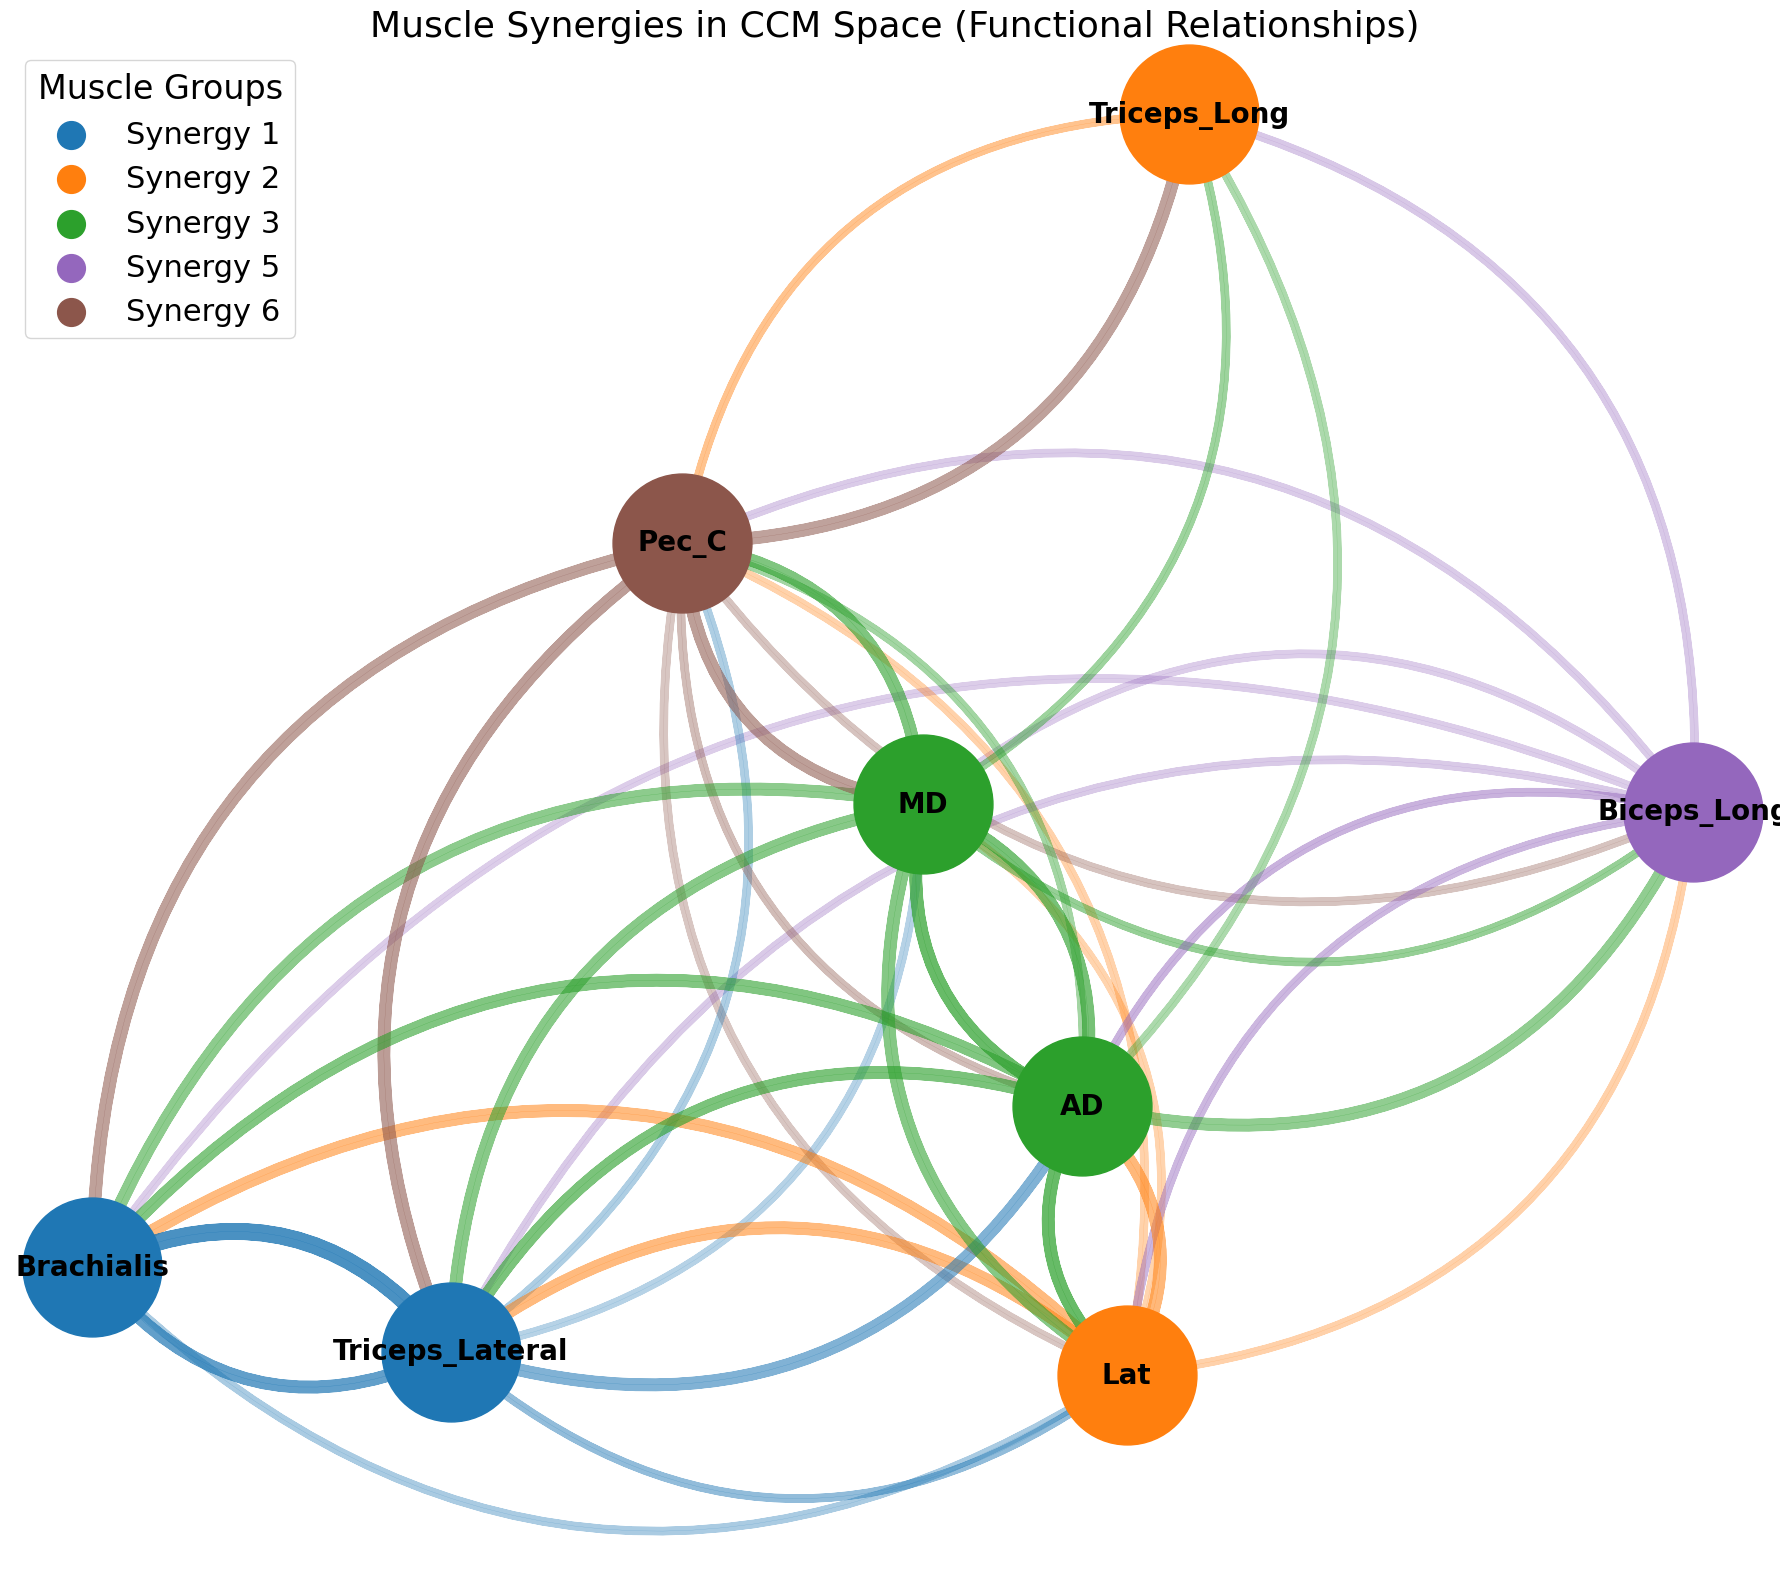

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import math
from matplotlib.colors import Normalize

# Load CCM matrix
ccm_df = pd.read_csv("ccm_actions_to_actions.csv", index_col=0)

# Fill diagonal NaN values with 1.0 (perfect self-prediction)
np.fill_diagonal(ccm_df.values, 1.0)

# Handle any remaining NaN values by replacing with zeros
ccm_matrix = np.nan_to_num(ccm_df.values)

# For spectral clustering, we use the CCM values directly as an adjacency matrix
# Higher CCM value = stronger causal connection
affinity_matrix = ccm_matrix

# Apply spectral clustering
n_clusters = 6  # Can be adjusted based on domain knowledge
spectral = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed',
                             random_state=42,
                             assign_labels='discretize')
cluster_labels = spectral.fit_predict(affinity_matrix)

# Create a DataFrame with muscle names and their cluster assignments
muscle_clusters = pd.DataFrame({
    'Muscle': ccm_df.index,
    'Cluster': cluster_labels + 1  # +1 to make clusters 1-indexed
})

# Create a dictionary mapping muscle to cluster for easy lookup
muscle_to_cluster = dict(zip(muscle_clusters['Muscle'], muscle_clusters['Cluster']))

# Display muscle synergy groups
print("Spectral clustering muscle synergies:")
for cluster in range(1, n_clusters+1):
    synergy_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    print(f"Synergy {cluster}: {', '.join(synergy_muscles)}")

# === Create graph from CCM matrix ===
G = nx.DiGraph()
for muscle in ccm_df.index:
    # Skip adding PD to the graph
    if muscle != "PD":
        G.add_node(muscle)

# Add edges with weights for strong causal connections - INCREASED THRESHOLD TO 0.5
for i, source in enumerate(ccm_df.index):
    if source == "PD":  # Skip PD as source
        continue
    for j, target in enumerate(ccm_df.columns):
        if target == "PD":  # Skip PD as target
            continue
        if i != j:  # Skip self-loops
            if not np.isnan(ccm_df.iloc[i, j]) and ccm_df.iloc[i, j] >= 0.5:
                G.add_edge(source, target, weight=ccm_df.iloc[i, j])

# === Create a distance matrix for MDS positioning ===
distance_matrix = np.zeros_like(ccm_matrix)
for i in range(len(ccm_df)):
    for j in range(len(ccm_df)):
        if i != j:
            # Use average of bidirectional values, transform to distance (1 - avg_ccm)
            avg_ccm = (ccm_matrix[i, j] + ccm_matrix[j, i]) / 2
            distance_matrix[i, j] = 1 - avg_ccm

# Use MDS to project the CCM relationships to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distance_matrix)

# Create positions dictionary for networkx (excluding PD)
pos_ccm = {}
for i, muscle in enumerate(ccm_df.index):
    if muscle != "PD":  # Skip PD
        pos_ccm[muscle] = (positions[i,0], positions[i,1])

# === Visualize the causal network in CCM space ===
fig, ax = plt.subplots(figsize=(18, 16))  # Even larger figure for better spacing

# Define node size - needed for arrow calculations
node_size = 10000

# Draw nodes colored by cluster - MUCH larger nodes
for cluster in range(1, n_clusters+1):
    nodes = [m for m in muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist() if m != "PD"]
    if nodes:  # Only draw if there are nodes in this cluster after filtering PD
        nx.draw_networkx_nodes(G, pos_ccm, nodelist=nodes, 
                              node_size=node_size,
                              node_color=f"C{cluster-1}", 
                              label=f"Synergy {cluster}",
                              ax=ax)

# Group edges by weight ranges for better visualization
edges = list(G.edges(data=True))
edges.sort(key=lambda x: x[2]['weight'])  # Sort by weight

# DRAMATICALLY INCREASED ARROW SIZES - weight ranges (adjusted for minimum 0.5)
# Further increased line widths for better visibility
weight_ranges = [
    (0.5, 0.65, 6, 35),   # (min_weight, max_weight, line_width, arrow_size)
    (0.65, 0.8, 9, 60),   # Increased line widths
    (0.8, 0.9, 12, 85),
    (0.9, 1.01, 15, 120)  # Very large arrows for strongest connections
]

# Calculate node radius for arrow positioning
node_radius = math.sqrt(node_size) * 0.35  # Adjusted for better positioning

print(f"Number of edges to draw: {len(edges)}")  # Debug info

# Create a mapping from node to its color
node_to_color = {}
for muscle in G.nodes():
    cluster_num = muscle_to_cluster.get(muscle)
    node_to_color[muscle] = f"C{cluster_num-1}"  # Use matplotlib color cycle

# Draw edges with different passes for each weight range - with proper edge connection
for min_w, max_w, width, arrow_size in weight_ranges:
    # Filter edges in this weight range
    range_edges = [(u, v, d) for u, v, d in edges if min_w <= d['weight'] < max_w]
    
    print(f"Edges in weight range {min_w}-{max_w}: {len(range_edges)}")  # Debug info
    
    if range_edges:  # Only draw if there are edges in this range
        for u, v, d in range_edges:
            # Get positions
            pos_u = pos_ccm[u]
            pos_v = pos_ccm[v]
            
            # Get origin node's color
            edge_color = node_to_color[u]
            
            # Calculate alpha based on CCM value (weight)
            # Map [0.5, 1.0] to [0.3, 1.0] for alpha
            min_alpha = 0.3
            max_alpha = 1.0
            alpha = min_alpha + (d['weight'] - 0.5) * ((max_alpha - min_alpha) / 0.5)
            
            # Create a FancyArrowPatch with shrinkage to stop at node boundaries
            arrow = mpatches.FancyArrowPatch(
                pos_u, pos_v,
                connectionstyle='arc3,rad=0.4',  # Increased curvature for visibility
                arrowstyle=f'simple,head_length={arrow_size*0.015},head_width={arrow_size*0.015}',
                linewidth=width,
                color=edge_color,  # Use origin node's color
                alpha=alpha,  # Use calculated alpha based on CCM strength
                shrinkA=node_radius,  # Shrink from start node
                shrinkB=node_radius,  # Shrink to end node
                zorder=0  # Ensure arrows appear behind nodes
            )
            
            ax.add_patch(arrow)
            print(f"Added arrow from {u} to {v} with weight {d['weight']:.2f}, alpha={alpha:.2f}")  # Debug info

# Add labels - bigger font to match larger nodes
nx.draw_networkx_labels(G, pos_ccm, font_size=20, font_weight='bold', ax=ax)  # Increased font size

# Create legend with smaller nodes but larger text
plt.title("Muscle Synergies in CCM Space (Functional Relationships)", fontsize=26)
legend = plt.legend(loc="upper left", fontsize=22, markerscale=0.2, title="Muscle Groups", frameon=True)
legend.get_title().set_fontsize(24)

# Add more margin to prevent cutoff
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.axis('off')
plt.tight_layout()
plt.savefig("ccm_space_muscle_synergies_origin_colored.png", dpi=300)
plt.show()

# === Create a reordered matrix visualization ===
ordered_muscles = []
for cluster in range(1, n_clusters+1):
    cluster_muscles = muscle_clusters[muscle_clusters['Cluster'] == cluster]['Muscle'].tolist()
    ordered_muscles.extend(cluster_muscles)

reordered_ccm = ccm_df.loc[ordered_muscles, ordered_muscles]

plt.figure(figsize=(10, 8))
sns.heatmap(reordered_ccm, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"label": "CCM ρ"})

# Add cluster boundary lines
muscle_count = 0
for cluster in range(1, n_clusters):
    cluster_size = len(muscle_clusters[muscle_clusters['Cluster'] == cluster])
    muscle_count += cluster_size
    plt.axhline(y=muscle_count, color='r', linestyle='-', linewidth=2)
    plt.axvline(x=muscle_count, color='r', linestyle='-', linewidth=2)

plt.title('Muscle Synergies from Spectral Clustering of CCM Relationships', fontsize=20)
plt.tight_layout()
plt.savefig('muscle_synergies_spectral.png', dpi=300)
plt.show()

In [ ]:
### SENSITIVITY ANALYSIS ### 
# === CCM analysis between actions and joints ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM
from tqdm import tqdm
from pyEDM import EmbedDimension
import h5py

## Load data for muscle activations (actions) and joint angles (qpos)
H5_Path = "rollouts_full_mouse_arm.h5"

with h5py.File(H5_Path, "r") as f:
    actions = f["actions"][...]
    qpos = f["qpos"][...]
    ref_qpos = f["ref_qpos"][...]
    decoder_activations = f["decoder_activations"]
    layer_0 = f["decoder_activations/layer_0"][:]
    layer_1 = f["decoder_activations/layer_1"][:]
    layer_2 = f["decoder_activations/layer_2"][:]
    intentions = f["intentions"][:]

    print(intentions.shape)
    print(decoder_activations.keys())
    print(layer_0.shape)
    print(layer_1.shape)
    print(layer_2.shape)

# Actions is a 46 clips by 100 frames by 9 actions
print(f"Action shape: {actions.shape}")

# Qpos is a 46 clips by 100 frames by 4 joint angles
print(f"Qpos shape: {qpos.shape}")
action_name = ["Pec_C", "Lat", "PD", "AD", "MD", "Triceps_Lateral", "Triceps_Long", "Brachialis", "Biceps_Long"]
qpos_name = ["sh_elv", "sh_ext", "sh_rot", "elbow"]

def plot_ccm_heatmap_from_csv(
    csv_path: str,
    title: str = "CCM ρ (actions → joints), plateau avg",
    output_png: str | None = None,
    annotate: bool = True,
) -> pd.DataFrame:
    """
    Load a (rows × columns) CCM matrix from CSV and plot a labeled heatmap.
    Labels (row index and column names) are used exactly as in the CSV.

    Args:
        csv_path: Path to CSV. First column must be row labels (e.g., muscles).
        title: Figure title string.
        output_png: If provided, save figure to this path; otherwise <csv_basename>.png.
        annotate: If True, annotate each cell with its numeric value.

    Returns:
        The DataFrame used to draw the heatmap.
    """
    # 1) Load exactly as-is (no renaming)
    df = pd.read_csv(csv_path, index_col=0)
    # Coerce to float where possible (keeps labels intact)
    df = df.apply(pd.to_numeric, errors="coerce")

    # 2) Plot
    fig_w = 1.2 * len(df.columns) + 2
    fig_h = 1.2 * len(df.index) + 2
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(df.values, aspect="auto")
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index)
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("ρ")

    # 3) Optional annotations with contrast-aware text color
    if annotate:
        vals = df.values
        vmin = np.nanmin(vals) if np.isfinite(vals).any() else 0.0
        vmax = np.nanmax(vals) if np.isfinite(vals).any() else 1.0
        thresh = (vmin + vmax) / 2.5
        for i in range(vals.shape[0]):
            for j in range(vals.shape[1]):
                v = vals[i, j]
                txt = "nan" if np.isnan(v) else f"{v:.2f}"
                color = "black" if (not np.isnan(v) and v >= thresh) else "white"
                ax.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)

    plt.tight_layout()

    # 4) Save if requested (default = same basename as CSV)
    if output_png is None:
        base, _ = os.path.splitext(os.path.basename(csv_path))
        output_png = f"{base}.png"
    plt.savefig(output_png, dpi=150)
    plt.show()

    return df

def concat_with_large_nan_padding(actions, qpos, pad=300, standardize=True):
    """
    Concatenate all clips into one long DataFrame with big NaN blocks between clips.
    Safe for pyEDM with ignoreNan=True.

    Args:
        actions: (N, T, 9)
        qpos:    (N, T, 4)
        pad:     number of NaN rows to insert between clips
        standardize: z-score each series per clip

    Returns:
        big_df: DataFrame with columns ['time','act0'..'act8','joint0'..'joint3']
        clip_ranges: dict {clip_idx: (start,end)} 1-based row indices (excluding NaNs)
    """
    N, T, A = actions.shape
    _, T2, J = qpos.shape
    assert T == T2 and A == 9 and J == 4

    def _z(x):
        mu, sd = np.nanmean(x), np.nanstd(x)
        return (x - mu)/sd if sd > 1e-12 else (x - mu)

    frames = []
    clip_ranges = {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({
                "time": np.arange(row_cursor+1, row_cursor+pad+1),
                **{f"act{i}": np.nan for i in range(A)},
                **{f"joint{j}": np.nan for j in range(J)},
            })
            frames.append(pad_df)
            row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        for i in range(A):
            data[f"act{i}"] = _z(actions[c,:,i]) if standardize else actions[c,:,i]
        for j in range(J):
            data[f"joint{j}"] = _z(qpos[c,:,j]) if standardize else qpos[c,:,j]
        clip_df = pd.DataFrame(data)

        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)

        frames.append(clip_df)
        row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

# Prepare data for CCM
big_df, clip_ranges = concat_with_large_nan_padding(actions, qpos, pad=10)

# Find optimal embedding dimensions
_keys = big_df.columns.tolist()
for key in _keys:
    # Run EmbedDimension on each variable across all clips pooled
    res = EmbedDimension(
        dataFrame=big_df,
        columns=key, target=key,
        lib="1 7000", pred="7000 9650",   # pick ranges that are inside big_df length
        ignoreNan=True, numProcess=1, showPlot=False
    )
    embedding_dim = res["rho"].argmax() + 1
    print(f"Embedding dimension for {key}: {embedding_dim}")

def ccm_heatmap_actions_to_joints(
    df: pd.DataFrame,
    action_names: list,
    joint_names: list,
    lib_sizes: str = "100 8000 200",
    samples: int = 50,
    E: int = 6,  # Using same embedding dimension as the action-to-action analysis
    tau: int = -1,
    tail_points: int = 5,
    output_csv: str = "ccm_actions_to_joints.csv",
    output_png: str = "ccm_actions_to_joints.png"
) -> pd.DataFrame:
    """
    Run CCM for all action-to-joint pairs and create a heatmap.
    
    Args:
        df: DataFrame with actions ('act0' through 'act8') and joints ('joint0' through 'joint3')
        action_names: Human-readable names for the actions
        joint_names: Human-readable names for the joints
        lib_sizes, samples, E, tau: CCM parameters
        tail_points: Number of last library sizes to average for plateau value
        output_csv/output_png: Output file paths
        
    Returns:
        DataFrame with CCM plateau values
    """
    num_actions = len(action_names)
    num_joints = len(joint_names)
    
    action_cols = [f"act{i}" for i in range(num_actions)]
    joint_cols = [f"joint{j}" for j in range(num_joints)]
    
    # Matrix to store CCM plateau values
    ccm_matrix = np.zeros((num_actions, num_joints))
    
    # Run CCM for each action-joint pair
    for i in tqdm(range(num_actions), desc="CCM action→joint"):
        for j in range(num_joints):
            # action_i → joint_j is tested as joint_j::action_i
            # (columns=joint_j, target=action_i)
            try:
                res = CCM(
                    dataFrame=df,
                    columns=joint_cols[j], 
                    target=action_cols[i],
                    E=E, tau=tau, Tp=0,
                    libSizes=lib_sizes, sample=samples,
                    ignoreNan=True, showPlot=True
                )
                
                # Get the right column name for this direction
                dir_col = f"{joint_cols[j]}:{action_cols[i]}"
                if dir_col in res.columns:
                    rho_series = res[dir_col]
                else:
                    # Fallback: first non-LibSize column
                    rho_series = res.iloc[:, 1]  # Assuming LibSize is first column
                
                # Get plateau value (average of last few points)
                k = min(tail_points, len(rho_series))
                plateau_rho = float(rho_series.iloc[-k:].mean()) if k > 0 else np.nan
                ccm_matrix[i, j] = plateau_rho
                
            except Exception as e:
                print(f"Error for {action_names[i]}→{joint_names[j]}: {e}")
                ccm_matrix[i, j] = np.nan
    
    # Create and save DataFrame
    ccm_df = pd.DataFrame(ccm_matrix, index=action_names, columns=joint_names)
    ccm_df.to_csv(output_csv, float_format="%.6f")
    
    # Plot heatmap
    plot_ccm_heatmap_from_csv(
        csv_path=output_csv,
        title="CCM ρ (action → joint), plateau avg",
        output_png=output_png,
        annotate=True
    )
    
    return ccm_df

def ccm_heatmap_joints_to_actions(
    df: pd.DataFrame,
    joint_names: list,
    action_names: list,
    lib_sizes: str = "100 8000 200",
    samples: int = 50,
    E: int = 6,
    tau: int = -1,
    tail_points: int = 5,
    output_csv: str = "ccm_joints_to_actions.csv",
    output_png: str = "ccm_joints_to_actions.png"
) -> pd.DataFrame:
    """
    Run CCM for all joint-to-action pairs and create a heatmap.
    
    Args:
        df: DataFrame with joints ('joint0' through 'joint3') and actions ('act0' through 'act8')
        joint_names: Human-readable names for the joints
        action_names: Human-readable names for the actions
        lib_sizes, samples, E, tau: CCM parameters
        tail_points: Number of last library sizes to average for plateau value
        output_csv/output_png: Output file paths
        
    Returns:
        DataFrame with CCM plateau values
    """
    num_joints = len(joint_names)
    num_actions = len(action_names)
    
    joint_cols = [f"joint{j}" for j in range(num_joints)]
    action_cols = [f"act{i}" for i in range(num_actions)]
    
    # Matrix to store CCM plateau values
    ccm_matrix = np.zeros((num_joints, num_actions))
    
    # Run CCM for each joint-action pair
    for i in tqdm(range(num_joints), desc="CCM joint→action"):
        for j in range(num_actions):
            # joint_i → action_j is tested as action_j::joint_i
            # (columns=action_j, target=joint_i)
            try:
                res = CCM(
                    dataFrame=df,
                    columns=action_cols[j], 
                    target=joint_cols[i],
                    E=E, tau=tau, Tp=0,
                    libSizes=lib_sizes, sample=samples,
                    ignoreNan=True, showPlot=True
                )
                
                # Get the right column name for this direction
                dir_col = f"{action_cols[j]}:{joint_cols[i]}"
                if dir_col in res.columns:
                    rho_series = res[dir_col]
                else:
                    # Fallback: first non-LibSize column
                    rho_series = res.iloc[:, 1]  # Assuming LibSize is first column
                
                # Get plateau value (average of last few points)
                k = min(tail_points, len(rho_series))
                plateau_rho = float(rho_series.iloc[-k:].mean()) if k > 0 else np.nan
                ccm_matrix[i, j] = plateau_rho
                
            except Exception as e:
                print(f"Error for {joint_names[i]}→{action_names[j]}: {e}")
                ccm_matrix[i, j] = np.nan
    
    # Create and save DataFrame
    ccm_df = pd.DataFrame(ccm_matrix, index=joint_names, columns=action_names)
    ccm_df.to_csv(output_csv, float_format="%.6f")
    
    # Plot heatmap
    plot_ccm_heatmap_from_csv(
        csv_path=output_csv,
        title="CCM ρ (joint → action), plateau avg",
        output_png=output_png,
        annotate=True
    )
    
    return ccm_df

# Run both types of CCM analysis
# 1. Run actions → joints CCM (muscle activations predicting joint angles)
ccm_matrix_a2j = ccm_heatmap_actions_to_joints(
    df=big_df,
    action_names=action_name,
    joint_names=qpos_name,
    lib_sizes="100 1000 200",
    samples=50,
    E=6,
    tau=-1,
    output_csv="ccm_actions_to_joints.csv",
    output_png="ccm_actions_to_joints.png"
)

# 2. Run joints → actions CCM (joint angles predicting muscle activations)
ccm_matrix_j2a = ccm_heatmap_joints_to_actions(
    df=big_df,
    joint_names=qpos_name,
    action_names=action_name,
    lib_sizes="100 2000 200",
    samples=50,
    E=2,
    tau=-1,
    output_csv="ccm_joints_to_actions.csv",
    output_png="ccm_joints_to_actions.png"
)

print("CCM analysis complete. Saved results to CSV files and generated heatmap visualizations.")

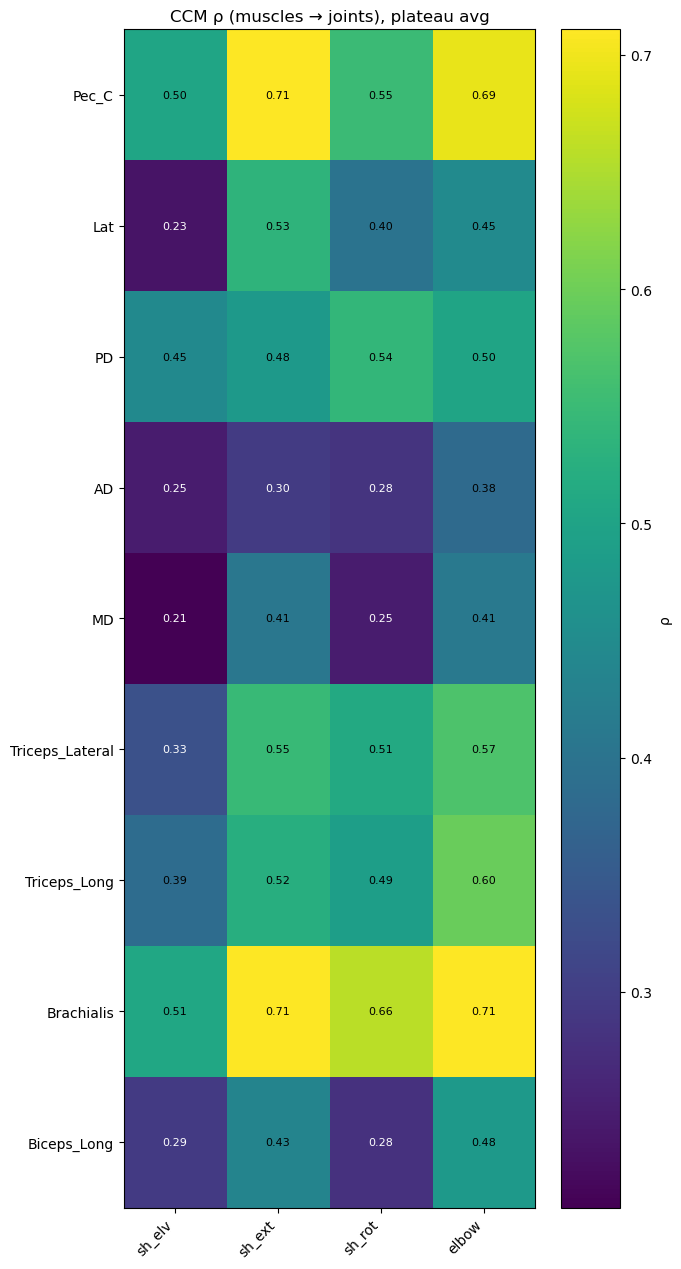

In [41]:
### SENSITIVITY ANALYSIS ### 
# === Plot CCM heatmap directly from CSV (no renaming) ==========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ccm_heatmap_from_csv(
    csv_path: str,
    title: str = "CCM ρ (actions → joints), plateau avg",
    output_png: str | None = None,
    annotate: bool = True,
) -> pd.DataFrame:
    """
    Load a (rows × columns) CCM matrix from CSV and plot a labeled heatmap.
    Labels (row index and column names) are used exactly as in the CSV.

    Args:
        csv_path: Path to CSV. First column must be row labels (e.g., muscles).
        title: Figure title string.
        output_png: If provided, save figure to this path; otherwise <csv_basename>.png.
        annotate: If True, annotate each cell with its numeric value.

    Returns:
        The DataFrame used to draw the heatmap.
    """
    # 1) Load exactly as-is (no renaming)
    df = pd.read_csv(csv_path, index_col=0)
    # Coerce to float where possible (keeps labels intact)
    df = df.apply(pd.to_numeric, errors="coerce")

    # 2) Plot
    fig_w = 1.2 * len(df.columns) + 2
    fig_h = 1.2 * len(df.index) + 2
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(df.values, aspect="auto")
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index)
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("ρ")

    # 3) Optional annotations with contrast-aware text color
    if annotate:
        vals = df.values
        vmin = np.nanmin(vals) if np.isfinite(vals).any() else 0.0
        vmax = np.nanmax(vals) if np.isfinite(vals).any() else 1.0
        thresh = (vmin + vmax) / 2.5
        for i in range(vals.shape[0]):
            for j in range(vals.shape[1]):
                v = vals[i, j]
                txt = "nan" if np.isnan(v) else f"{v:.2f}"
                color = "black" if (not np.isnan(v) and v >= thresh) else "white"
                ax.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)

    plt.tight_layout()

    # 4) Save if requested (default = same basename as CSV)
    if output_png is None:
        base, _ = os.path.splitext(os.path.basename(csv_path))
        output_png = f"{base}.png"
    plt.savefig(output_png, dpi=150)
    plt.show()

    return df

# ---- Use it -------------------------------------------------------------
_ = plot_ccm_heatmap_from_csv(
    "ccm_actions_to_joints.csv",
    title="CCM ρ (muscles → joints), plateau avg",
    output_png="ccm_actions_to_joints.png",
    annotate=True,
)
